In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
TARGET_SAMPLE_RATE = 44100
TARGET_AUDIO_LENGTH = 15 * TARGET_SAMPLE_RATE
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}

# Load dataset
csv_file = "/content/drive/MyDrive/Moodify-CDS-2025/data/set1_tracklist.csv"
df = pd.read_csv(csv_file)
df["Emotion"] = df["Emotion"].str.capitalize()
desired_emotions = ["Happy", "Sad", "Fear", "Anger"]
df = df[df["Emotion"].isin(desired_emotions)].reset_index(drop=True)
df["File"] = df["Nro"].astype(str).str.zfill(3) + ".mp3"
data_dir = "/content/drive/MyDrive/Moodify-CDS-2025/data/Set1"

# Collate Function
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = pad_sequence(waveforms, batch_first=True)
    labels = torch.tensor(labels)
    return waveforms, labels

# Audio preprocessing
class Stereo2Mono(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.tensor([0.5, 0.5], requires_grad=False).view(2, 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            return torch.sum(waveform * self.weights, dim=0) * np.sqrt(2)
        return waveform

def path_to_waveform_tensor(path: str, sample_rate=TARGET_SAMPLE_RATE):
    waveform, sr = torchaudio.load(path)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    mono_wf = Stereo2Mono()(waveform)
    return mono_wf.squeeze(0).cpu()

def split_waveform_segments(wf: torch.Tensor, target_len=TARGET_AUDIO_LENGTH, min_length: int=TARGET_SAMPLE_RATE * 10, train: bool=False):
    wf_len = wf.shape[0]
    if wf_len < target_len:
        return [wf.detach().clone()] if wf_len >= min_length else []
    else:
        hop_length = target_len // 2 if train else target_len
        segments = []
        for i in range(0, wf_len, hop_length):
            if wf_len - i > target_len:
                segments.append(wf[i:i+target_len])
            elif wf_len - i >= min_length:
                segments.append(wf[-target_len if train else i:])
        return segments

# Dataset
class AudioEmotionDataset(Dataset):
    def __init__(self, dataframe, data_dir, train=True):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.train = train
        self.data = []
        self.labels = []
        self.prepare_dataset()

    def prepare_dataset(self):
        for _, row in tqdm(self.dataframe.iterrows(), total=len(self.dataframe)):
            audio_path = os.path.join(self.data_dir, row["File"])
            label = LABEL_TO_INT[row["Emotion"]]
            try:
                wf = path_to_waveform_tensor(audio_path)
                segments = split_waveform_segments(wf, train=self.train)
                self.data.extend(segments)
                self.labels.extend([label] * len(segments))
            except Exception as e:
                print(f"Error loading {audio_path}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y


class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )
        # Ensure that the tensor is moved to CPU before applying librosa function
        self.norm = lambda x: torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))

    def forward(self, x):
        x = self.melspec(x)
        x = self.norm(x)
        return x

# Positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Improved Transformer
class ImprovedEmotionTransformer(nn.Module):
    def __init__(self, input_dim=128, num_classes=4, d_model=128, nhead=8, num_layers=4, dropout=0.7):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)               # (B, T, F)
        x = self.input_proj(x)               # (B, T, D)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)               # (T, B, D)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)                    # (B, D)
        x = self.dropout(x)
        return self.fc_out(x)

# Dataset and Dataloader
full_dataset = AudioEmotionDataset(df, data_dir, train=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)

# Initialize model and training utils
extractor = FeatureExtractor().to(device)
# model = ImprovedEmotionTransformer().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)

        optimizer.zero_grad()
        outputs = model(x_feat)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)
        outputs = model(x_feat)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=INT_TO_LABEL.values()))


100%|██████████| 120/120 [00:05<00:00, 22.68it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ImprovedEmotionTransformer(
  (input_proj): Linear(in_features=128, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.7, inplace=False)
        (dropout2): Dropout(p=0.7, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc_out): Linear(in_features=128, out_features=4, bias=True)
)


Epoch 1/100: 100%|██████████| 34/34 [00:00<00:00, 48.85it/s]


Epoch 1/100, Loss: 1.5030


Epoch 2/100: 100%|██████████| 34/34 [00:00<00:00, 51.27it/s]


Epoch 2/100, Loss: 1.4791


Epoch 3/100: 100%|██████████| 34/34 [00:00<00:00, 51.87it/s]


Epoch 3/100, Loss: 1.4533


Epoch 4/100: 100%|██████████| 34/34 [00:00<00:00, 51.16it/s]


Epoch 4/100, Loss: 1.4297


Epoch 5/100: 100%|██████████| 34/34 [00:00<00:00, 51.98it/s]


Epoch 5/100, Loss: 1.4588


Epoch 6/100: 100%|██████████| 34/34 [00:00<00:00, 52.21it/s]


Epoch 6/100, Loss: 1.4238


Epoch 7/100: 100%|██████████| 34/34 [00:00<00:00, 50.99it/s]


Epoch 7/100, Loss: 1.3635


Epoch 8/100: 100%|██████████| 34/34 [00:00<00:00, 51.97it/s]


Epoch 8/100, Loss: 1.4321


Epoch 9/100: 100%|██████████| 34/34 [00:00<00:00, 50.48it/s]


Epoch 9/100, Loss: 1.4454


Epoch 10/100: 100%|██████████| 34/34 [00:00<00:00, 49.79it/s]


Epoch 10/100, Loss: 1.3725


Epoch 11/100: 100%|██████████| 34/34 [00:00<00:00, 48.90it/s]


Epoch 11/100, Loss: 1.3991


Epoch 12/100: 100%|██████████| 34/34 [00:00<00:00, 48.64it/s]


Epoch 12/100, Loss: 1.3702


Epoch 13/100: 100%|██████████| 34/34 [00:00<00:00, 51.10it/s]


Epoch 13/100, Loss: 1.3867


Epoch 14/100: 100%|██████████| 34/34 [00:00<00:00, 51.35it/s]


Epoch 14/100, Loss: 1.3982


Epoch 15/100: 100%|██████████| 34/34 [00:00<00:00, 50.65it/s]


Epoch 15/100, Loss: 1.3651


Epoch 16/100: 100%|██████████| 34/34 [00:00<00:00, 51.26it/s]


Epoch 16/100, Loss: 1.3299


Epoch 17/100: 100%|██████████| 34/34 [00:00<00:00, 50.60it/s]


Epoch 17/100, Loss: 1.3017


Epoch 18/100: 100%|██████████| 34/34 [00:00<00:00, 50.43it/s]


Epoch 18/100, Loss: 1.3760


Epoch 19/100: 100%|██████████| 34/34 [00:00<00:00, 51.45it/s]


Epoch 19/100, Loss: 1.2937


Epoch 20/100: 100%|██████████| 34/34 [00:00<00:00, 50.81it/s]


Epoch 20/100, Loss: 1.4066


Epoch 21/100: 100%|██████████| 34/34 [00:00<00:00, 51.02it/s]


Epoch 21/100, Loss: 1.2633


Epoch 22/100: 100%|██████████| 34/34 [00:00<00:00, 50.43it/s]


Epoch 22/100, Loss: 1.2557


Epoch 23/100: 100%|██████████| 34/34 [00:00<00:00, 50.18it/s]


Epoch 23/100, Loss: 1.2269


Epoch 24/100: 100%|██████████| 34/34 [00:00<00:00, 52.02it/s]


Epoch 24/100, Loss: 1.1743


Epoch 25/100: 100%|██████████| 34/34 [00:00<00:00, 51.74it/s]


Epoch 25/100, Loss: 1.2104


Epoch 26/100: 100%|██████████| 34/34 [00:00<00:00, 51.86it/s]


Epoch 26/100, Loss: 1.1853


Epoch 27/100: 100%|██████████| 34/34 [00:00<00:00, 50.32it/s]


Epoch 27/100, Loss: 1.1970


Epoch 28/100: 100%|██████████| 34/34 [00:00<00:00, 48.80it/s]


Epoch 28/100, Loss: 1.1398


Epoch 29/100: 100%|██████████| 34/34 [00:00<00:00, 49.48it/s]


Epoch 29/100, Loss: 1.1892


Epoch 30/100: 100%|██████████| 34/34 [00:00<00:00, 50.58it/s]


Epoch 30/100, Loss: 1.1854


Epoch 31/100: 100%|██████████| 34/34 [00:00<00:00, 50.75it/s]


Epoch 31/100, Loss: 1.1539


Epoch 32/100: 100%|██████████| 34/34 [00:00<00:00, 51.63it/s]


Epoch 32/100, Loss: 1.0404


Epoch 33/100: 100%|██████████| 34/34 [00:00<00:00, 50.69it/s]


Epoch 33/100, Loss: 1.2112


Epoch 34/100: 100%|██████████| 34/34 [00:00<00:00, 50.46it/s]


Epoch 34/100, Loss: 1.0999


Epoch 35/100: 100%|██████████| 34/34 [00:00<00:00, 50.82it/s]


Epoch 35/100, Loss: 1.0641


Epoch 36/100: 100%|██████████| 34/34 [00:00<00:00, 52.04it/s]


Epoch 36/100, Loss: 1.0018


Epoch 37/100: 100%|██████████| 34/34 [00:00<00:00, 50.90it/s]


Epoch 37/100, Loss: 1.0067


Epoch 38/100: 100%|██████████| 34/34 [00:00<00:00, 51.90it/s]


Epoch 38/100, Loss: 0.9013


Epoch 39/100: 100%|██████████| 34/34 [00:00<00:00, 50.02it/s]


Epoch 39/100, Loss: 0.8906


Epoch 40/100: 100%|██████████| 34/34 [00:00<00:00, 51.72it/s]


Epoch 40/100, Loss: 0.8749


Epoch 41/100: 100%|██████████| 34/34 [00:00<00:00, 51.56it/s]


Epoch 41/100, Loss: 0.8754


Epoch 42/100: 100%|██████████| 34/34 [00:00<00:00, 51.20it/s]


Epoch 42/100, Loss: 0.8338


Epoch 43/100: 100%|██████████| 34/34 [00:00<00:00, 51.24it/s]


Epoch 43/100, Loss: 0.7550


Epoch 44/100: 100%|██████████| 34/34 [00:00<00:00, 51.69it/s]


Epoch 44/100, Loss: 0.7060


Epoch 45/100: 100%|██████████| 34/34 [00:00<00:00, 50.22it/s]


Epoch 45/100, Loss: 0.6983


Epoch 46/100: 100%|██████████| 34/34 [00:00<00:00, 49.90it/s]


Epoch 46/100, Loss: 0.6622


Epoch 47/100: 100%|██████████| 34/34 [00:00<00:00, 50.41it/s]


Epoch 47/100, Loss: 0.6446


Epoch 48/100: 100%|██████████| 34/34 [00:00<00:00, 48.65it/s]


Epoch 48/100, Loss: 0.5180


Epoch 49/100: 100%|██████████| 34/34 [00:00<00:00, 51.63it/s]


Epoch 49/100, Loss: 0.4409


Epoch 50/100: 100%|██████████| 34/34 [00:00<00:00, 50.88it/s]


Epoch 50/100, Loss: 0.3958


Epoch 51/100: 100%|██████████| 34/34 [00:00<00:00, 50.36it/s]


Epoch 51/100, Loss: 0.3926


Epoch 52/100: 100%|██████████| 34/34 [00:00<00:00, 51.35it/s]


Epoch 52/100, Loss: 0.3780


Epoch 53/100: 100%|██████████| 34/34 [00:00<00:00, 51.12it/s]


Epoch 53/100, Loss: 0.3438


Epoch 54/100: 100%|██████████| 34/34 [00:00<00:00, 51.74it/s]


Epoch 54/100, Loss: 0.3566


Epoch 55/100: 100%|██████████| 34/34 [00:00<00:00, 51.82it/s]


Epoch 55/100, Loss: 0.2951


Epoch 56/100: 100%|██████████| 34/34 [00:00<00:00, 51.22it/s]


Epoch 56/100, Loss: 0.2454


Epoch 57/100: 100%|██████████| 34/34 [00:00<00:00, 52.02it/s]


Epoch 57/100, Loss: 0.2400


Epoch 58/100: 100%|██████████| 34/34 [00:00<00:00, 51.60it/s]


Epoch 58/100, Loss: 0.2192


Epoch 59/100: 100%|██████████| 34/34 [00:00<00:00, 50.38it/s]


Epoch 59/100, Loss: 0.3157


Epoch 60/100: 100%|██████████| 34/34 [00:00<00:00, 49.13it/s]


Epoch 60/100, Loss: 0.2580


Epoch 61/100: 100%|██████████| 34/34 [00:00<00:00, 51.27it/s]


Epoch 61/100, Loss: 0.2797


Epoch 62/100: 100%|██████████| 34/34 [00:00<00:00, 51.33it/s]


Epoch 62/100, Loss: 0.4007


Epoch 63/100: 100%|██████████| 34/34 [00:00<00:00, 50.21it/s]


Epoch 63/100, Loss: 0.3726


Epoch 64/100: 100%|██████████| 34/34 [00:00<00:00, 47.77it/s]


Epoch 64/100, Loss: 0.3489


Epoch 65/100: 100%|██████████| 34/34 [00:00<00:00, 49.20it/s]


Epoch 65/100, Loss: 0.2360


Epoch 66/100: 100%|██████████| 34/34 [00:00<00:00, 50.42it/s]


Epoch 66/100, Loss: 0.1689


Epoch 67/100: 100%|██████████| 34/34 [00:00<00:00, 49.86it/s]


Epoch 67/100, Loss: 0.1468


Epoch 68/100: 100%|██████████| 34/34 [00:00<00:00, 51.74it/s]


Epoch 68/100, Loss: 0.1406


Epoch 69/100: 100%|██████████| 34/34 [00:00<00:00, 49.89it/s]


Epoch 69/100, Loss: 0.1027


Epoch 70/100: 100%|██████████| 34/34 [00:00<00:00, 50.75it/s]


Epoch 70/100, Loss: 0.1229


Epoch 71/100: 100%|██████████| 34/34 [00:00<00:00, 52.38it/s]


Epoch 71/100, Loss: 0.1354


Epoch 72/100: 100%|██████████| 34/34 [00:00<00:00, 51.59it/s]


Epoch 72/100, Loss: 0.1231


Epoch 73/100: 100%|██████████| 34/34 [00:00<00:00, 50.80it/s]


Epoch 73/100, Loss: 0.1089


Epoch 74/100: 100%|██████████| 34/34 [00:00<00:00, 51.79it/s]


Epoch 74/100, Loss: 0.1277


Epoch 75/100: 100%|██████████| 34/34 [00:00<00:00, 51.74it/s]


Epoch 75/100, Loss: 0.1417


Epoch 76/100: 100%|██████████| 34/34 [00:00<00:00, 51.27it/s]


Epoch 76/100, Loss: 0.1695


Epoch 77/100: 100%|██████████| 34/34 [00:00<00:00, 51.25it/s]


Epoch 77/100, Loss: 0.1691


Epoch 78/100: 100%|██████████| 34/34 [00:00<00:00, 50.33it/s]


Epoch 78/100, Loss: 0.0768


Epoch 79/100: 100%|██████████| 34/34 [00:00<00:00, 50.93it/s]


Epoch 79/100, Loss: 0.0684


Epoch 80/100: 100%|██████████| 34/34 [00:00<00:00, 51.42it/s]


Epoch 80/100, Loss: 0.0630


Epoch 81/100: 100%|██████████| 34/34 [00:00<00:00, 50.24it/s]


Epoch 81/100, Loss: 0.0506


Epoch 82/100: 100%|██████████| 34/34 [00:00<00:00, 51.41it/s]


Epoch 82/100, Loss: 0.0430


Epoch 83/100: 100%|██████████| 34/34 [00:00<00:00, 50.35it/s]


Epoch 83/100, Loss: 0.0474


Epoch 84/100: 100%|██████████| 34/34 [00:00<00:00, 50.04it/s]


Epoch 84/100, Loss: 0.0495


Epoch 85/100: 100%|██████████| 34/34 [00:00<00:00, 51.65it/s]


Epoch 85/100, Loss: 0.0353


Epoch 86/100: 100%|██████████| 34/34 [00:00<00:00, 50.63it/s]


Epoch 86/100, Loss: 0.0370


Epoch 87/100: 100%|██████████| 34/34 [00:00<00:00, 51.93it/s]


Epoch 87/100, Loss: 0.0329


Epoch 88/100: 100%|██████████| 34/34 [00:00<00:00, 52.05it/s]


Epoch 88/100, Loss: 0.0337


Epoch 89/100: 100%|██████████| 34/34 [00:00<00:00, 51.19it/s]


Epoch 89/100, Loss: 0.0333


Epoch 90/100: 100%|██████████| 34/34 [00:00<00:00, 52.28it/s]


Epoch 90/100, Loss: 0.0321


Epoch 91/100: 100%|██████████| 34/34 [00:00<00:00, 51.76it/s]


Epoch 91/100, Loss: 0.0302


Epoch 92/100: 100%|██████████| 34/34 [00:00<00:00, 51.63it/s]


Epoch 92/100, Loss: 0.0240


Epoch 93/100: 100%|██████████| 34/34 [00:00<00:00, 52.03it/s]


Epoch 93/100, Loss: 0.0274


Epoch 94/100: 100%|██████████| 34/34 [00:00<00:00, 51.00it/s]


Epoch 94/100, Loss: 0.0258


Epoch 95/100: 100%|██████████| 34/34 [00:00<00:00, 50.84it/s]


Epoch 95/100, Loss: 0.0238


Epoch 96/100: 100%|██████████| 34/34 [00:00<00:00, 50.62it/s]


Epoch 96/100, Loss: 0.0213


Epoch 97/100: 100%|██████████| 34/34 [00:00<00:00, 50.10it/s]


Epoch 97/100, Loss: 0.0229


Epoch 98/100: 100%|██████████| 34/34 [00:00<00:00, 51.46it/s]


Epoch 98/100, Loss: 0.0232


Epoch 99/100: 100%|██████████| 34/34 [00:00<00:00, 48.75it/s]


Epoch 99/100, Loss: 0.0210


Epoch 100/100: 100%|██████████| 34/34 [00:00<00:00, 48.97it/s]


Epoch 100/100, Loss: 0.0204


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 96.24it/s]

              precision    recall  f1-score   support

       Happy       0.00      0.00      0.00         7
         Sad       0.86      0.60      0.71        10
        Fear       0.41      0.90      0.56        10
       Anger       0.80      0.57      0.67         7

    accuracy                           0.56        34
   macro avg       0.52      0.52      0.48        34
weighted avg       0.54      0.56      0.51        34




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)
# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)

        optimizer.zero_grad()
        outputs = model(x_feat)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)
        outputs = model(x_feat)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=INT_TO_LABEL.values()))


Epoch 1/50: 100%|██████████| 34/34 [00:00<00:00, 49.01it/s]


Epoch 1/50, Loss: 0.0031


Epoch 2/50: 100%|██████████| 34/34 [00:00<00:00, 51.52it/s]


Epoch 2/50, Loss: 0.0046


Epoch 3/50: 100%|██████████| 34/34 [00:00<00:00, 50.79it/s]


Epoch 3/50, Loss: 0.0039


Epoch 4/50: 100%|██████████| 34/34 [00:00<00:00, 51.37it/s]


Epoch 4/50, Loss: 0.0029


Epoch 5/50: 100%|██████████| 34/34 [00:00<00:00, 50.51it/s]


Epoch 5/50, Loss: 0.0033


Epoch 6/50: 100%|██████████| 34/34 [00:00<00:00, 50.56it/s]


Epoch 6/50, Loss: 0.0042


Epoch 7/50: 100%|██████████| 34/34 [00:00<00:00, 51.68it/s]


Epoch 7/50, Loss: 0.0035


Epoch 8/50: 100%|██████████| 34/34 [00:00<00:00, 51.76it/s]


Epoch 8/50, Loss: 0.0057


Epoch 9/50: 100%|██████████| 34/34 [00:00<00:00, 50.33it/s]


Epoch 9/50, Loss: 0.0040


Epoch 10/50: 100%|██████████| 34/34 [00:00<00:00, 51.69it/s]


Epoch 10/50, Loss: 0.0037


Epoch 11/50: 100%|██████████| 34/34 [00:00<00:00, 50.56it/s]


Epoch 11/50, Loss: 0.0037


Epoch 12/50: 100%|██████████| 34/34 [00:00<00:00, 50.06it/s]


Epoch 12/50, Loss: 0.0035


Epoch 13/50: 100%|██████████| 34/34 [00:00<00:00, 50.69it/s]


Epoch 13/50, Loss: 0.0043


Epoch 14/50: 100%|██████████| 34/34 [00:00<00:00, 48.91it/s]


Epoch 14/50, Loss: 0.0035


Epoch 15/50: 100%|██████████| 34/34 [00:00<00:00, 51.64it/s]


Epoch 15/50, Loss: 0.0040


Epoch 16/50: 100%|██████████| 34/34 [00:00<00:00, 51.22it/s]


Epoch 16/50, Loss: 0.0037


Epoch 17/50: 100%|██████████| 34/34 [00:00<00:00, 50.56it/s]


Epoch 17/50, Loss: 0.0039


Epoch 18/50: 100%|██████████| 34/34 [00:00<00:00, 51.84it/s]


Epoch 18/50, Loss: 0.0038


Epoch 19/50: 100%|██████████| 34/34 [00:00<00:00, 52.14it/s]


Epoch 19/50, Loss: 0.0053


Epoch 20/50: 100%|██████████| 34/34 [00:00<00:00, 50.49it/s]


Epoch 20/50, Loss: 0.0057


Epoch 21/50: 100%|██████████| 34/34 [00:00<00:00, 51.87it/s]


Epoch 21/50, Loss: 0.0032


Epoch 22/50: 100%|██████████| 34/34 [00:00<00:00, 51.41it/s]


Epoch 22/50, Loss: 0.0042


Epoch 23/50: 100%|██████████| 34/34 [00:00<00:00, 52.45it/s]


Epoch 23/50, Loss: 0.0038


Epoch 24/50: 100%|██████████| 34/34 [00:00<00:00, 51.25it/s]


Epoch 24/50, Loss: 0.0033


Epoch 25/50: 100%|██████████| 34/34 [00:00<00:00, 50.92it/s]


Epoch 25/50, Loss: 0.0038


Epoch 26/50: 100%|██████████| 34/34 [00:00<00:00, 51.69it/s]


Epoch 26/50, Loss: 0.0033


Epoch 27/50: 100%|██████████| 34/34 [00:00<00:00, 49.89it/s]


Epoch 27/50, Loss: 0.0032


Epoch 28/50: 100%|██████████| 34/34 [00:00<00:00, 50.72it/s]


Epoch 28/50, Loss: 0.0047


Epoch 29/50: 100%|██████████| 34/34 [00:00<00:00, 50.57it/s]


Epoch 29/50, Loss: 0.0037


Epoch 30/50: 100%|██████████| 34/34 [00:00<00:00, 48.34it/s]


Epoch 30/50, Loss: 0.0028


Epoch 31/50: 100%|██████████| 34/34 [00:00<00:00, 50.67it/s]


Epoch 31/50, Loss: 0.0030


Epoch 32/50: 100%|██████████| 34/34 [00:00<00:00, 48.28it/s]


Epoch 32/50, Loss: 0.0037


Epoch 33/50: 100%|██████████| 34/34 [00:00<00:00, 51.32it/s]


Epoch 33/50, Loss: 0.0047


Epoch 34/50: 100%|██████████| 34/34 [00:00<00:00, 51.42it/s]


Epoch 34/50, Loss: 0.0034


Epoch 35/50: 100%|██████████| 34/34 [00:00<00:00, 51.13it/s]


Epoch 35/50, Loss: 0.0050


Epoch 36/50: 100%|██████████| 34/34 [00:00<00:00, 50.35it/s]


Epoch 36/50, Loss: 0.0037


Epoch 37/50: 100%|██████████| 34/34 [00:00<00:00, 51.64it/s]


Epoch 37/50, Loss: 0.0033


Epoch 38/50: 100%|██████████| 34/34 [00:00<00:00, 49.91it/s]


Epoch 38/50, Loss: 0.0045


Epoch 39/50: 100%|██████████| 34/34 [00:00<00:00, 49.65it/s]


Epoch 39/50, Loss: 0.0044


Epoch 40/50: 100%|██████████| 34/34 [00:00<00:00, 50.06it/s]


Epoch 40/50, Loss: 0.0030


Epoch 41/50: 100%|██████████| 34/34 [00:00<00:00, 50.50it/s]


Epoch 41/50, Loss: 0.0034


Epoch 42/50: 100%|██████████| 34/34 [00:00<00:00, 50.28it/s]


Epoch 42/50, Loss: 0.0049


Epoch 43/50: 100%|██████████| 34/34 [00:00<00:00, 51.18it/s]


Epoch 43/50, Loss: 0.0032


Epoch 44/50: 100%|██████████| 34/34 [00:00<00:00, 50.35it/s]


Epoch 44/50, Loss: 0.0046


Epoch 45/50: 100%|██████████| 34/34 [00:00<00:00, 50.21it/s]


Epoch 45/50, Loss: 0.0044


Epoch 46/50: 100%|██████████| 34/34 [00:00<00:00, 50.51it/s]


Epoch 46/50, Loss: 0.0036


Epoch 47/50: 100%|██████████| 34/34 [00:00<00:00, 48.91it/s]


Epoch 47/50, Loss: 0.0038


Epoch 48/50: 100%|██████████| 34/34 [00:00<00:00, 48.50it/s]


Epoch 48/50, Loss: 0.0035


Epoch 49/50: 100%|██████████| 34/34 [00:00<00:00, 48.88it/s]


Epoch 49/50, Loss: 0.0035


Epoch 50/50: 100%|██████████| 34/34 [00:00<00:00, 49.92it/s]


Epoch 50/50, Loss: 0.0050


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 102.59it/s]

              precision    recall  f1-score   support

       Happy       0.67      0.29      0.40         7
         Sad       0.83      0.50      0.62        10
        Fear       0.41      0.70      0.52        10
       Anger       0.62      0.71      0.67         7

    accuracy                           0.56        34
   macro avg       0.63      0.55      0.55        34
weighted avg       0.63      0.56      0.56        34



In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
TARGET_SAMPLE_RATE = 44100  # Set default sample rate
TARGET_AUDIO_LENGTH = 15 * TARGET_SAMPLE_RATE  # 15 seconds
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}  # You can adjust this based on dataset
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}

csv_file = "/content/drive/MyDrive/Moodify-CDS-2025/data/set1_tracklist.csv"
df = pd.read_csv(csv_file)
df["Emotion"] = df["Emotion"].str.capitalize()
desired_emotions = ["Happy", "Sad", "Fear", "Anger"]
df = df[df["Emotion"].isin(desired_emotions)].reset_index(drop=True)
df["File"] = df["Nro"].astype(str).str.zfill(3) + ".mp3"
data_dir = "/content/drive/MyDrive/Moodify-CDS-2025/data/Set1"
# Collate function for batching
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = pad_sequence(waveforms, batch_first=True)
    labels = torch.tensor(labels)
    return waveforms, labels

# Audio preprocessing
class Stereo2Mono(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.tensor([0.5, 0.5], requires_grad=False).view(2, 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            return torch.sum(waveform * self.weights, dim=0) * np.sqrt(2)
        return waveform

def path_to_waveform_tensor(path: str, sample_rate=TARGET_SAMPLE_RATE):
    waveform, sr = torchaudio.load(path)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    mono_wf = Stereo2Mono()(waveform)
    return mono_wf.squeeze(0).cpu()

def split_waveform_segments(wf: torch.Tensor, target_len=TARGET_AUDIO_LENGTH, min_length: int=TARGET_SAMPLE_RATE * 10, train: bool=False):
    wf_len = wf.shape[0]
    if wf_len < target_len:
        return [wf.detach().clone()] if wf_len >= min_length else []
    else:
        hop_length = target_len // 2 if train else target_len
        segments = []
        for i in range(0, wf_len, hop_length):
            if wf_len - i > target_len:
                segments.append(wf[i:i+target_len])
            elif wf_len - i >= min_length:
                segments.append(wf[-target_len if train else i:])
        return segments

# Data augmentation class
class AudioAugmentation(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_stretch = torchaudio.transforms.TimeStretch()
        self.pitch_shift = torchaudio.transforms.PitchShift(sample_rate=TARGET_SAMPLE_RATE)
        self.noise_injection = torchaudio.transforms.AdditiveNoise(noise_level=0.01)

    def forward(self, x):
        if np.random.random() > 0.5:
            x = self.time_stretch(x)
        if np.random.random() > 0.5:
            x = self.pitch_shift(x)
        if np.random.random() > 0.5:
            x = self.noise_injection(x)
        return x

# Feature extraction
class FeatureExtractor(nn.Module):
    def __init__(self, feature_type='melspec'):
        super().__init__()
        if feature_type == 'melspec':
            self.feature_extractor = torchaudio.transforms.MelSpectrogram(
                sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096
            )
        elif feature_type == 'mfcc':
            self.feature_extractor = torchaudio.transforms.MFCC(
                sample_rate=TARGET_SAMPLE_RATE, n_mfcc=13
            )
        else:
            raise ValueError("Unsupported feature type")
        self.norm = lambda x: torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.norm(x)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer Model
class ImprovedEmotionTransformer(nn.Module):
    def __init__(self, input_dim=128, num_classes=4, d_model=128, nhead=4, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, T, F)
        x = self.input_proj(x)  # (B, T, D)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # (T, B, D)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # (B, D)
        x = self.dropout(x)
        return self.fc_out(x)

# Dataset class
class AudioEmotionDataset(Dataset):
    def __init__(self, dataframe, data_dir, train=True):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.train = train
        self.data = []
        self.labels = []
        self.prepare_dataset()

    def prepare_dataset(self):
        for _, row in tqdm(self.dataframe.iterrows(), total=len(self.dataframe)):
            audio_path = os.path.join(self.data_dir, row["File"])
            label = LABEL_TO_INT[row["Emotion"]]
            try:
                wf = path_to_waveform_tensor(audio_path)
                segments = split_waveform_segments(wf, train=self.train)
                self.data.extend(segments)
                self.labels.extend([label] * len(segments))
            except Exception as e:
                print(f"Error loading {audio_path}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

# Dataset and DataLoader setup
full_dataset = AudioEmotionDataset(df, data_dir, train=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn)

# Model, criterion, and optimizer
extractor = FeatureExtractor(feature_type='melspec').to(device)  # Choose 'melspec' or 'mfcc'
# model = ImprovedEmotionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)

        optimizer.zero_grad()
        outputs = model(x_feat)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)
        outputs = model(x_feat)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=INT_TO_LABEL.values()))


Epoch 1/300: 100%|██████████| 17/17 [00:00<00:00, 38.38it/s]


Epoch 1/300, Loss: 0.2986


Epoch 2/300: 100%|██████████| 17/17 [00:00<00:00, 38.56it/s]


Epoch 2/300, Loss: 0.1358


Epoch 3/300: 100%|██████████| 17/17 [00:00<00:00, 37.84it/s]


Epoch 3/300, Loss: 0.0156


Epoch 4/300: 100%|██████████| 17/17 [00:00<00:00, 38.76it/s]


Epoch 4/300, Loss: 0.0084


Epoch 5/300: 100%|██████████| 17/17 [00:00<00:00, 39.35it/s]


Epoch 5/300, Loss: 0.0033


Epoch 6/300: 100%|██████████| 17/17 [00:00<00:00, 38.50it/s]


Epoch 6/300, Loss: 0.0024


Epoch 7/300: 100%|██████████| 17/17 [00:00<00:00, 39.82it/s]


Epoch 7/300, Loss: 0.0027


Epoch 8/300: 100%|██████████| 17/17 [00:00<00:00, 40.00it/s]


Epoch 8/300, Loss: 0.0030


Epoch 9/300: 100%|██████████| 17/17 [00:00<00:00, 38.44it/s]


Epoch 9/300, Loss: 0.0041


Epoch 10/300: 100%|██████████| 17/17 [00:00<00:00, 38.04it/s]


Epoch 10/300, Loss: 0.0038


Epoch 11/300: 100%|██████████| 17/17 [00:00<00:00, 38.47it/s]


Epoch 11/300, Loss: 0.0633


Epoch 12/300: 100%|██████████| 17/17 [00:00<00:00, 37.88it/s]


Epoch 12/300, Loss: 0.0582


Epoch 13/300: 100%|██████████| 17/17 [00:00<00:00, 38.71it/s]


Epoch 13/300, Loss: 0.3833


Epoch 14/300: 100%|██████████| 17/17 [00:00<00:00, 37.79it/s]


Epoch 14/300, Loss: 0.3777


Epoch 15/300: 100%|██████████| 17/17 [00:00<00:00, 38.54it/s]


Epoch 15/300, Loss: 0.1177


Epoch 16/300: 100%|██████████| 17/17 [00:00<00:00, 38.46it/s]


Epoch 16/300, Loss: 0.0339


Epoch 17/300: 100%|██████████| 17/17 [00:00<00:00, 38.11it/s]


Epoch 17/300, Loss: 0.1668


Epoch 18/300: 100%|██████████| 17/17 [00:00<00:00, 36.97it/s]


Epoch 18/300, Loss: 0.0604


Epoch 19/300: 100%|██████████| 17/17 [00:00<00:00, 38.14it/s]


Epoch 19/300, Loss: 0.2866


Epoch 20/300: 100%|██████████| 17/17 [00:00<00:00, 37.21it/s]


Epoch 20/300, Loss: 0.1029


Epoch 21/300: 100%|██████████| 17/17 [00:00<00:00, 36.30it/s]


Epoch 21/300, Loss: 0.3058


Epoch 22/300: 100%|██████████| 17/17 [00:00<00:00, 37.03it/s]


Epoch 22/300, Loss: 0.1558


Epoch 23/300: 100%|██████████| 17/17 [00:00<00:00, 39.11it/s]


Epoch 23/300, Loss: 0.0409


Epoch 24/300: 100%|██████████| 17/17 [00:00<00:00, 38.77it/s]


Epoch 24/300, Loss: 0.0157


Epoch 25/300: 100%|██████████| 17/17 [00:00<00:00, 38.12it/s]


Epoch 25/300, Loss: 0.0537


Epoch 26/300: 100%|██████████| 17/17 [00:00<00:00, 39.22it/s]


Epoch 26/300, Loss: 0.0375


Epoch 27/300: 100%|██████████| 17/17 [00:00<00:00, 38.35it/s]


Epoch 27/300, Loss: 0.0061


Epoch 28/300: 100%|██████████| 17/17 [00:00<00:00, 38.89it/s]


Epoch 28/300, Loss: 0.0042


Epoch 29/300: 100%|██████████| 17/17 [00:00<00:00, 38.67it/s]


Epoch 29/300, Loss: 0.0298


Epoch 30/300: 100%|██████████| 17/17 [00:00<00:00, 39.85it/s]


Epoch 30/300, Loss: 0.0084


Epoch 31/300: 100%|██████████| 17/17 [00:00<00:00, 37.64it/s]


Epoch 31/300, Loss: 0.0031


Epoch 32/300: 100%|██████████| 17/17 [00:00<00:00, 38.50it/s]


Epoch 32/300, Loss: 0.0039


Epoch 33/300: 100%|██████████| 17/17 [00:00<00:00, 39.11it/s]


Epoch 33/300, Loss: 0.0033


Epoch 34/300: 100%|██████████| 17/17 [00:00<00:00, 39.54it/s]


Epoch 34/300, Loss: 0.0034


Epoch 35/300: 100%|██████████| 17/17 [00:00<00:00, 37.97it/s]


Epoch 35/300, Loss: 0.0031


Epoch 36/300: 100%|██████████| 17/17 [00:00<00:00, 39.21it/s]


Epoch 36/300, Loss: 0.0040


Epoch 37/300: 100%|██████████| 17/17 [00:00<00:00, 39.54it/s]


Epoch 37/300, Loss: 0.0031


Epoch 38/300: 100%|██████████| 17/17 [00:00<00:00, 38.21it/s]


Epoch 38/300, Loss: 0.0022


Epoch 39/300: 100%|██████████| 17/17 [00:00<00:00, 38.05it/s]


Epoch 39/300, Loss: 0.0031


Epoch 40/300: 100%|██████████| 17/17 [00:00<00:00, 38.42it/s]


Epoch 40/300, Loss: 0.0030


Epoch 41/300: 100%|██████████| 17/17 [00:00<00:00, 36.72it/s]


Epoch 41/300, Loss: 0.0037


Epoch 42/300: 100%|██████████| 17/17 [00:00<00:00, 39.33it/s]


Epoch 42/300, Loss: 0.0024


Epoch 43/300: 100%|██████████| 17/17 [00:00<00:00, 39.75it/s]


Epoch 43/300, Loss: 0.0018


Epoch 44/300: 100%|██████████| 17/17 [00:00<00:00, 40.14it/s]


Epoch 44/300, Loss: 0.0028


Epoch 45/300: 100%|██████████| 17/17 [00:00<00:00, 37.53it/s]


Epoch 45/300, Loss: 0.0028


Epoch 46/300: 100%|██████████| 17/17 [00:00<00:00, 37.14it/s]


Epoch 46/300, Loss: 0.0029


Epoch 47/300: 100%|██████████| 17/17 [00:00<00:00, 34.87it/s]


Epoch 47/300, Loss: 0.0026


Epoch 48/300: 100%|██████████| 17/17 [00:00<00:00, 36.87it/s]


Epoch 48/300, Loss: 0.0025


Epoch 49/300: 100%|██████████| 17/17 [00:00<00:00, 36.10it/s]


Epoch 49/300, Loss: 0.0036


Epoch 50/300: 100%|██████████| 17/17 [00:00<00:00, 38.59it/s]


Epoch 50/300, Loss: 0.0029


Epoch 51/300: 100%|██████████| 17/17 [00:00<00:00, 38.69it/s]


Epoch 51/300, Loss: 0.0025


Epoch 52/300: 100%|██████████| 17/17 [00:00<00:00, 38.38it/s]


Epoch 52/300, Loss: 0.0020


Epoch 53/300: 100%|██████████| 17/17 [00:00<00:00, 38.85it/s]


Epoch 53/300, Loss: 0.0018


Epoch 54/300: 100%|██████████| 17/17 [00:00<00:00, 38.99it/s]


Epoch 54/300, Loss: 0.0026


Epoch 55/300: 100%|██████████| 17/17 [00:00<00:00, 38.51it/s]


Epoch 55/300, Loss: 0.0021


Epoch 56/300: 100%|██████████| 17/17 [00:00<00:00, 38.51it/s]


Epoch 56/300, Loss: 0.0022


Epoch 57/300: 100%|██████████| 17/17 [00:00<00:00, 39.52it/s]


Epoch 57/300, Loss: 0.0030


Epoch 58/300: 100%|██████████| 17/17 [00:00<00:00, 38.19it/s]


Epoch 58/300, Loss: 0.0037


Epoch 59/300: 100%|██████████| 17/17 [00:00<00:00, 39.36it/s]


Epoch 59/300, Loss: 0.0026


Epoch 60/300: 100%|██████████| 17/17 [00:00<00:00, 38.34it/s]


Epoch 60/300, Loss: 0.0029


Epoch 61/300: 100%|██████████| 17/17 [00:00<00:00, 39.21it/s]


Epoch 61/300, Loss: 0.0019


Epoch 62/300: 100%|██████████| 17/17 [00:00<00:00, 40.40it/s]


Epoch 62/300, Loss: 0.0026


Epoch 63/300: 100%|██████████| 17/17 [00:00<00:00, 38.09it/s]


Epoch 63/300, Loss: 0.0019


Epoch 64/300: 100%|██████████| 17/17 [00:00<00:00, 39.14it/s]


Epoch 64/300, Loss: 0.0022


Epoch 65/300: 100%|██████████| 17/17 [00:00<00:00, 39.20it/s]


Epoch 65/300, Loss: 0.0019


Epoch 66/300: 100%|██████████| 17/17 [00:00<00:00, 38.41it/s]


Epoch 66/300, Loss: 0.0020


Epoch 67/300: 100%|██████████| 17/17 [00:00<00:00, 39.33it/s]


Epoch 67/300, Loss: 0.0021


Epoch 68/300: 100%|██████████| 17/17 [00:00<00:00, 38.85it/s]


Epoch 68/300, Loss: 0.0020


Epoch 69/300: 100%|██████████| 17/17 [00:00<00:00, 39.32it/s]


Epoch 69/300, Loss: 0.0020


Epoch 70/300: 100%|██████████| 17/17 [00:00<00:00, 39.55it/s]


Epoch 70/300, Loss: 0.0019


Epoch 71/300: 100%|██████████| 17/17 [00:00<00:00, 38.93it/s]


Epoch 71/300, Loss: 0.0016


Epoch 72/300: 100%|██████████| 17/17 [00:00<00:00, 37.29it/s]


Epoch 72/300, Loss: 0.0019


Epoch 73/300: 100%|██████████| 17/17 [00:00<00:00, 38.66it/s]


Epoch 73/300, Loss: 0.0017


Epoch 74/300: 100%|██████████| 17/17 [00:00<00:00, 38.44it/s]


Epoch 74/300, Loss: 0.0031


Epoch 75/300: 100%|██████████| 17/17 [00:00<00:00, 37.85it/s]


Epoch 75/300, Loss: 0.0016


Epoch 76/300: 100%|██████████| 17/17 [00:00<00:00, 36.51it/s]


Epoch 76/300, Loss: 0.0015


Epoch 77/300: 100%|██████████| 17/17 [00:00<00:00, 38.23it/s]


Epoch 77/300, Loss: 0.0019


Epoch 78/300: 100%|██████████| 17/17 [00:00<00:00, 38.46it/s]


Epoch 78/300, Loss: 0.0017


Epoch 79/300: 100%|██████████| 17/17 [00:00<00:00, 39.51it/s]


Epoch 79/300, Loss: 0.0024


Epoch 80/300: 100%|██████████| 17/17 [00:00<00:00, 39.43it/s]


Epoch 80/300, Loss: 0.0017


Epoch 81/300: 100%|██████████| 17/17 [00:00<00:00, 37.71it/s]


Epoch 81/300, Loss: 0.0016


Epoch 82/300: 100%|██████████| 17/17 [00:00<00:00, 38.67it/s]


Epoch 82/300, Loss: 0.0020


Epoch 83/300: 100%|██████████| 17/17 [00:00<00:00, 39.82it/s]


Epoch 83/300, Loss: 0.0013


Epoch 84/300: 100%|██████████| 17/17 [00:00<00:00, 38.84it/s]


Epoch 84/300, Loss: 0.0014


Epoch 85/300: 100%|██████████| 17/17 [00:00<00:00, 39.01it/s]


Epoch 85/300, Loss: 0.0022


Epoch 86/300: 100%|██████████| 17/17 [00:00<00:00, 39.85it/s]


Epoch 86/300, Loss: 0.0021


Epoch 87/300: 100%|██████████| 17/17 [00:00<00:00, 38.62it/s]


Epoch 87/300, Loss: 0.0027


Epoch 88/300: 100%|██████████| 17/17 [00:00<00:00, 39.79it/s]


Epoch 88/300, Loss: 0.0015


Epoch 89/300: 100%|██████████| 17/17 [00:00<00:00, 40.05it/s]


Epoch 89/300, Loss: 0.0012


Epoch 90/300: 100%|██████████| 17/17 [00:00<00:00, 40.09it/s]


Epoch 90/300, Loss: 0.0020


Epoch 91/300: 100%|██████████| 17/17 [00:00<00:00, 38.60it/s]


Epoch 91/300, Loss: 0.0023


Epoch 92/300: 100%|██████████| 17/17 [00:00<00:00, 39.02it/s]


Epoch 92/300, Loss: 0.0016


Epoch 93/300: 100%|██████████| 17/17 [00:00<00:00, 38.13it/s]


Epoch 93/300, Loss: 0.0018


Epoch 94/300: 100%|██████████| 17/17 [00:00<00:00, 38.39it/s]


Epoch 94/300, Loss: 0.0016


Epoch 95/300: 100%|██████████| 17/17 [00:00<00:00, 38.63it/s]


Epoch 95/300, Loss: 0.0018


Epoch 96/300: 100%|██████████| 17/17 [00:00<00:00, 38.77it/s]


Epoch 96/300, Loss: 0.0018


Epoch 97/300: 100%|██████████| 17/17 [00:00<00:00, 38.91it/s]


Epoch 97/300, Loss: 0.0017


Epoch 98/300: 100%|██████████| 17/17 [00:00<00:00, 38.65it/s]


Epoch 98/300, Loss: 0.0019


Epoch 99/300: 100%|██████████| 17/17 [00:00<00:00, 39.00it/s]


Epoch 99/300, Loss: 0.0012


Epoch 100/300: 100%|██████████| 17/17 [00:00<00:00, 37.74it/s]


Epoch 100/300, Loss: 0.0015


Epoch 101/300: 100%|██████████| 17/17 [00:00<00:00, 38.06it/s]


Epoch 101/300, Loss: 0.0020


Epoch 102/300: 100%|██████████| 17/17 [00:00<00:00, 37.46it/s]


Epoch 102/300, Loss: 0.0023


Epoch 103/300: 100%|██████████| 17/17 [00:00<00:00, 38.05it/s]


Epoch 103/300, Loss: 0.0014


Epoch 104/300: 100%|██████████| 17/17 [00:00<00:00, 36.71it/s]


Epoch 104/300, Loss: 0.0017


Epoch 105/300: 100%|██████████| 17/17 [00:00<00:00, 37.36it/s]


Epoch 105/300, Loss: 0.0012


Epoch 106/300: 100%|██████████| 17/17 [00:00<00:00, 38.72it/s]


Epoch 106/300, Loss: 0.0016


Epoch 107/300: 100%|██████████| 17/17 [00:00<00:00, 39.99it/s]


Epoch 107/300, Loss: 0.0016


Epoch 108/300: 100%|██████████| 17/17 [00:00<00:00, 38.42it/s]


Epoch 108/300, Loss: 0.0019


Epoch 109/300: 100%|██████████| 17/17 [00:00<00:00, 38.49it/s]


Epoch 109/300, Loss: 0.0015


Epoch 110/300: 100%|██████████| 17/17 [00:00<00:00, 37.07it/s]


Epoch 110/300, Loss: 0.0018


Epoch 111/300: 100%|██████████| 17/17 [00:00<00:00, 39.12it/s]


Epoch 111/300, Loss: 0.0019


Epoch 112/300: 100%|██████████| 17/17 [00:00<00:00, 39.01it/s]


Epoch 112/300, Loss: 0.0017


Epoch 113/300: 100%|██████████| 17/17 [00:00<00:00, 38.42it/s]


Epoch 113/300, Loss: 0.0016


Epoch 114/300: 100%|██████████| 17/17 [00:00<00:00, 39.50it/s]


Epoch 114/300, Loss: 0.0020


Epoch 115/300: 100%|██████████| 17/17 [00:00<00:00, 39.83it/s]


Epoch 115/300, Loss: 0.0011


Epoch 116/300: 100%|██████████| 17/17 [00:00<00:00, 38.86it/s]


Epoch 116/300, Loss: 0.0015


Epoch 117/300: 100%|██████████| 17/17 [00:00<00:00, 39.22it/s]


Epoch 117/300, Loss: 0.0016


Epoch 118/300: 100%|██████████| 17/17 [00:00<00:00, 38.70it/s]


Epoch 118/300, Loss: 0.0011


Epoch 119/300: 100%|██████████| 17/17 [00:00<00:00, 39.78it/s]


Epoch 119/300, Loss: 0.0011


Epoch 120/300: 100%|██████████| 17/17 [00:00<00:00, 39.94it/s]


Epoch 120/300, Loss: 0.0021


Epoch 121/300: 100%|██████████| 17/17 [00:00<00:00, 39.12it/s]


Epoch 121/300, Loss: 0.0013


Epoch 122/300: 100%|██████████| 17/17 [00:00<00:00, 39.34it/s]


Epoch 122/300, Loss: 0.0010


Epoch 123/300: 100%|██████████| 17/17 [00:00<00:00, 39.31it/s]


Epoch 123/300, Loss: 0.0014


Epoch 124/300: 100%|██████████| 17/17 [00:00<00:00, 38.07it/s]


Epoch 124/300, Loss: 0.0013


Epoch 125/300: 100%|██████████| 17/17 [00:00<00:00, 40.11it/s]


Epoch 125/300, Loss: 0.0012


Epoch 126/300: 100%|██████████| 17/17 [00:00<00:00, 39.58it/s]


Epoch 126/300, Loss: 0.0011


Epoch 127/300: 100%|██████████| 17/17 [00:00<00:00, 37.55it/s]


Epoch 127/300, Loss: 0.0015


Epoch 128/300: 100%|██████████| 17/17 [00:00<00:00, 36.65it/s]


Epoch 128/300, Loss: 0.0010


Epoch 129/300: 100%|██████████| 17/17 [00:00<00:00, 38.11it/s]


Epoch 129/300, Loss: 0.0018


Epoch 130/300: 100%|██████████| 17/17 [00:00<00:00, 38.31it/s]


Epoch 130/300, Loss: 0.0011


Epoch 131/300: 100%|██████████| 17/17 [00:00<00:00, 36.03it/s]


Epoch 131/300, Loss: 0.0012


Epoch 132/300: 100%|██████████| 17/17 [00:00<00:00, 38.77it/s]


Epoch 132/300, Loss: 0.0015


Epoch 133/300: 100%|██████████| 17/17 [00:00<00:00, 38.36it/s]


Epoch 133/300, Loss: 0.0014


Epoch 134/300: 100%|██████████| 17/17 [00:00<00:00, 37.72it/s]


Epoch 134/300, Loss: 0.0012


Epoch 135/300: 100%|██████████| 17/17 [00:00<00:00, 39.29it/s]


Epoch 135/300, Loss: 0.0015


Epoch 136/300: 100%|██████████| 17/17 [00:00<00:00, 39.40it/s]


Epoch 136/300, Loss: 0.0021


Epoch 137/300: 100%|██████████| 17/17 [00:00<00:00, 39.58it/s]


Epoch 137/300, Loss: 0.0020


Epoch 138/300: 100%|██████████| 17/17 [00:00<00:00, 38.74it/s]


Epoch 138/300, Loss: 0.0010


Epoch 139/300: 100%|██████████| 17/17 [00:00<00:00, 39.36it/s]


Epoch 139/300, Loss: 0.0009


Epoch 140/300: 100%|██████████| 17/17 [00:00<00:00, 39.10it/s]


Epoch 140/300, Loss: 0.0014


Epoch 141/300: 100%|██████████| 17/17 [00:00<00:00, 38.87it/s]


Epoch 141/300, Loss: 0.0013


Epoch 142/300: 100%|██████████| 17/17 [00:00<00:00, 39.11it/s]


Epoch 142/300, Loss: 0.0012


Epoch 143/300: 100%|██████████| 17/17 [00:00<00:00, 40.00it/s]


Epoch 143/300, Loss: 0.0017


Epoch 144/300: 100%|██████████| 17/17 [00:00<00:00, 39.66it/s]


Epoch 144/300, Loss: 0.0012


Epoch 145/300: 100%|██████████| 17/17 [00:00<00:00, 38.49it/s]


Epoch 145/300, Loss: 0.0015


Epoch 146/300: 100%|██████████| 17/17 [00:00<00:00, 39.77it/s]


Epoch 146/300, Loss: 0.0016


Epoch 147/300: 100%|██████████| 17/17 [00:00<00:00, 37.76it/s]


Epoch 147/300, Loss: 0.0011


Epoch 148/300: 100%|██████████| 17/17 [00:00<00:00, 38.26it/s]


Epoch 148/300, Loss: 0.0012


Epoch 149/300: 100%|██████████| 17/17 [00:00<00:00, 38.66it/s]


Epoch 149/300, Loss: 0.0012


Epoch 150/300: 100%|██████████| 17/17 [00:00<00:00, 39.05it/s]


Epoch 150/300, Loss: 0.0020


Epoch 151/300: 100%|██████████| 17/17 [00:00<00:00, 39.11it/s]


Epoch 151/300, Loss: 0.0010


Epoch 152/300: 100%|██████████| 17/17 [00:00<00:00, 38.90it/s]


Epoch 152/300, Loss: 0.0012


Epoch 153/300: 100%|██████████| 17/17 [00:00<00:00, 38.29it/s]


Epoch 153/300, Loss: 0.0010


Epoch 154/300: 100%|██████████| 17/17 [00:00<00:00, 39.03it/s]


Epoch 154/300, Loss: 0.0013


Epoch 155/300: 100%|██████████| 17/17 [00:00<00:00, 37.30it/s]


Epoch 155/300, Loss: 0.0010


Epoch 156/300: 100%|██████████| 17/17 [00:00<00:00, 35.99it/s]


Epoch 156/300, Loss: 0.0010


Epoch 157/300: 100%|██████████| 17/17 [00:00<00:00, 39.27it/s]


Epoch 157/300, Loss: 0.0012


Epoch 158/300: 100%|██████████| 17/17 [00:00<00:00, 37.11it/s]


Epoch 158/300, Loss: 0.0006


Epoch 159/300: 100%|██████████| 17/17 [00:00<00:00, 38.59it/s]


Epoch 159/300, Loss: 0.0011


Epoch 160/300: 100%|██████████| 17/17 [00:00<00:00, 39.62it/s]


Epoch 160/300, Loss: 0.0014


Epoch 161/300: 100%|██████████| 17/17 [00:00<00:00, 39.54it/s]


Epoch 161/300, Loss: 0.0012


Epoch 162/300: 100%|██████████| 17/17 [00:00<00:00, 39.32it/s]


Epoch 162/300, Loss: 0.0011


Epoch 163/300: 100%|██████████| 17/17 [00:00<00:00, 39.56it/s]


Epoch 163/300, Loss: 0.0013


Epoch 164/300: 100%|██████████| 17/17 [00:00<00:00, 39.96it/s]


Epoch 164/300, Loss: 0.0014


Epoch 165/300: 100%|██████████| 17/17 [00:00<00:00, 39.50it/s]


Epoch 165/300, Loss: 0.0013


Epoch 166/300: 100%|██████████| 17/17 [00:00<00:00, 39.27it/s]


Epoch 166/300, Loss: 0.0013


Epoch 167/300: 100%|██████████| 17/17 [00:00<00:00, 38.74it/s]


Epoch 167/300, Loss: 0.0013


Epoch 168/300: 100%|██████████| 17/17 [00:00<00:00, 39.18it/s]


Epoch 168/300, Loss: 0.0010


Epoch 169/300: 100%|██████████| 17/17 [00:00<00:00, 38.64it/s]


Epoch 169/300, Loss: 0.0009


Epoch 170/300: 100%|██████████| 17/17 [00:00<00:00, 38.05it/s]


Epoch 170/300, Loss: 0.0021


Epoch 171/300: 100%|██████████| 17/17 [00:00<00:00, 38.77it/s]


Epoch 171/300, Loss: 0.0012


Epoch 172/300: 100%|██████████| 17/17 [00:00<00:00, 39.01it/s]


Epoch 172/300, Loss: 0.0012


Epoch 173/300: 100%|██████████| 17/17 [00:00<00:00, 38.71it/s]


Epoch 173/300, Loss: 0.0014


Epoch 174/300: 100%|██████████| 17/17 [00:00<00:00, 38.35it/s]


Epoch 174/300, Loss: 0.0008


Epoch 175/300: 100%|██████████| 17/17 [00:00<00:00, 37.48it/s]


Epoch 175/300, Loss: 0.0012


Epoch 176/300: 100%|██████████| 17/17 [00:00<00:00, 37.82it/s]


Epoch 176/300, Loss: 0.0012


Epoch 177/300: 100%|██████████| 17/17 [00:00<00:00, 39.59it/s]


Epoch 177/300, Loss: 0.0009


Epoch 178/300: 100%|██████████| 17/17 [00:00<00:00, 39.77it/s]


Epoch 178/300, Loss: 0.0009


Epoch 179/300: 100%|██████████| 17/17 [00:00<00:00, 38.04it/s]


Epoch 179/300, Loss: 0.0007


Epoch 180/300: 100%|██████████| 17/17 [00:00<00:00, 39.24it/s]


Epoch 180/300, Loss: 0.0009


Epoch 181/300: 100%|██████████| 17/17 [00:00<00:00, 37.77it/s]


Epoch 181/300, Loss: 0.0013


Epoch 182/300: 100%|██████████| 17/17 [00:00<00:00, 37.33it/s]


Epoch 182/300, Loss: 0.0010


Epoch 183/300: 100%|██████████| 17/17 [00:00<00:00, 36.67it/s]


Epoch 183/300, Loss: 0.0010


Epoch 184/300: 100%|██████████| 17/17 [00:00<00:00, 37.07it/s]


Epoch 184/300, Loss: 0.0008


Epoch 185/300: 100%|██████████| 17/17 [00:00<00:00, 37.39it/s]


Epoch 185/300, Loss: 0.0013


Epoch 186/300: 100%|██████████| 17/17 [00:00<00:00, 37.05it/s]


Epoch 186/300, Loss: 0.0006


Epoch 187/300: 100%|██████████| 17/17 [00:00<00:00, 39.08it/s]


Epoch 187/300, Loss: 0.0010


Epoch 188/300: 100%|██████████| 17/17 [00:00<00:00, 38.47it/s]


Epoch 188/300, Loss: 0.0007


Epoch 189/300: 100%|██████████| 17/17 [00:00<00:00, 39.38it/s]


Epoch 189/300, Loss: 0.0012


Epoch 190/300: 100%|██████████| 17/17 [00:00<00:00, 38.95it/s]


Epoch 190/300, Loss: 0.0014


Epoch 191/300: 100%|██████████| 17/17 [00:00<00:00, 39.39it/s]


Epoch 191/300, Loss: 0.0008


Epoch 192/300: 100%|██████████| 17/17 [00:00<00:00, 39.52it/s]


Epoch 192/300, Loss: 0.0009


Epoch 193/300: 100%|██████████| 17/17 [00:00<00:00, 39.79it/s]


Epoch 193/300, Loss: 0.0008


Epoch 194/300: 100%|██████████| 17/17 [00:00<00:00, 38.70it/s]


Epoch 194/300, Loss: 0.0010


Epoch 195/300: 100%|██████████| 17/17 [00:00<00:00, 39.34it/s]


Epoch 195/300, Loss: 0.0007


Epoch 196/300: 100%|██████████| 17/17 [00:00<00:00, 39.47it/s]


Epoch 196/300, Loss: 0.0008


Epoch 197/300: 100%|██████████| 17/17 [00:00<00:00, 39.68it/s]


Epoch 197/300, Loss: 0.0011


Epoch 198/300: 100%|██████████| 17/17 [00:00<00:00, 38.22it/s]


Epoch 198/300, Loss: 0.0011


Epoch 199/300: 100%|██████████| 17/17 [00:00<00:00, 39.53it/s]


Epoch 199/300, Loss: 0.0010


Epoch 200/300: 100%|██████████| 17/17 [00:00<00:00, 39.11it/s]


Epoch 200/300, Loss: 0.0011


Epoch 201/300: 100%|██████████| 17/17 [00:00<00:00, 39.14it/s]


Epoch 201/300, Loss: 0.0008


Epoch 202/300: 100%|██████████| 17/17 [00:00<00:00, 37.82it/s]


Epoch 202/300, Loss: 0.0017


Epoch 203/300: 100%|██████████| 17/17 [00:00<00:00, 37.56it/s]


Epoch 203/300, Loss: 0.0011


Epoch 204/300: 100%|██████████| 17/17 [00:00<00:00, 39.69it/s]


Epoch 204/300, Loss: 0.0008


Epoch 205/300: 100%|██████████| 17/17 [00:00<00:00, 39.66it/s]


Epoch 205/300, Loss: 0.0009


Epoch 206/300: 100%|██████████| 17/17 [00:00<00:00, 38.99it/s]


Epoch 206/300, Loss: 0.0009


Epoch 207/300: 100%|██████████| 17/17 [00:00<00:00, 39.63it/s]


Epoch 207/300, Loss: 0.0011


Epoch 208/300: 100%|██████████| 17/17 [00:00<00:00, 40.00it/s]


Epoch 208/300, Loss: 0.0010


Epoch 209/300: 100%|██████████| 17/17 [00:00<00:00, 38.95it/s]


Epoch 209/300, Loss: 0.0012


Epoch 210/300: 100%|██████████| 17/17 [00:00<00:00, 37.54it/s]


Epoch 210/300, Loss: 0.0012


Epoch 211/300: 100%|██████████| 17/17 [00:00<00:00, 37.17it/s]


Epoch 211/300, Loss: 0.0008


Epoch 212/300: 100%|██████████| 17/17 [00:00<00:00, 37.99it/s]


Epoch 212/300, Loss: 0.0010


Epoch 213/300: 100%|██████████| 17/17 [00:00<00:00, 36.81it/s]


Epoch 213/300, Loss: 0.0009


Epoch 214/300: 100%|██████████| 17/17 [00:00<00:00, 38.53it/s]


Epoch 214/300, Loss: 0.0008


Epoch 215/300: 100%|██████████| 17/17 [00:00<00:00, 39.09it/s]


Epoch 215/300, Loss: 0.0010


Epoch 216/300: 100%|██████████| 17/17 [00:00<00:00, 38.49it/s]


Epoch 216/300, Loss: 0.0009


Epoch 217/300: 100%|██████████| 17/17 [00:00<00:00, 39.47it/s]


Epoch 217/300, Loss: 0.0010


Epoch 218/300: 100%|██████████| 17/17 [00:00<00:00, 39.87it/s]


Epoch 218/300, Loss: 0.0006


Epoch 219/300: 100%|██████████| 17/17 [00:00<00:00, 36.58it/s]


Epoch 219/300, Loss: 0.0010


Epoch 220/300: 100%|██████████| 17/17 [00:00<00:00, 39.30it/s]


Epoch 220/300, Loss: 0.0005


Epoch 221/300: 100%|██████████| 17/17 [00:00<00:00, 39.57it/s]


Epoch 221/300, Loss: 0.0009


Epoch 222/300: 100%|██████████| 17/17 [00:00<00:00, 39.68it/s]


Epoch 222/300, Loss: 0.0010


Epoch 223/300: 100%|██████████| 17/17 [00:00<00:00, 39.08it/s]


Epoch 223/300, Loss: 0.0007


Epoch 224/300: 100%|██████████| 17/17 [00:00<00:00, 38.47it/s]


Epoch 224/300, Loss: 0.0007


Epoch 225/300: 100%|██████████| 17/17 [00:00<00:00, 38.62it/s]


Epoch 225/300, Loss: 0.0008


Epoch 226/300: 100%|██████████| 17/17 [00:00<00:00, 39.22it/s]


Epoch 226/300, Loss: 0.0006


Epoch 227/300: 100%|██████████| 17/17 [00:00<00:00, 38.93it/s]


Epoch 227/300, Loss: 0.0006


Epoch 228/300: 100%|██████████| 17/17 [00:00<00:00, 38.59it/s]


Epoch 228/300, Loss: 0.0005


Epoch 229/300: 100%|██████████| 17/17 [00:00<00:00, 38.09it/s]


Epoch 229/300, Loss: 0.0006


Epoch 230/300: 100%|██████████| 17/17 [00:00<00:00, 38.89it/s]


Epoch 230/300, Loss: 0.0005


Epoch 231/300: 100%|██████████| 17/17 [00:00<00:00, 39.01it/s]


Epoch 231/300, Loss: 0.0006


Epoch 232/300: 100%|██████████| 17/17 [00:00<00:00, 39.81it/s]


Epoch 232/300, Loss: 0.0011


Epoch 233/300: 100%|██████████| 17/17 [00:00<00:00, 38.41it/s]


Epoch 233/300, Loss: 0.0007


Epoch 234/300: 100%|██████████| 17/17 [00:00<00:00, 38.39it/s]


Epoch 234/300, Loss: 0.0007


Epoch 235/300: 100%|██████████| 17/17 [00:00<00:00, 38.33it/s]


Epoch 235/300, Loss: 0.0007


Epoch 236/300: 100%|██████████| 17/17 [00:00<00:00, 39.23it/s]


Epoch 236/300, Loss: 0.0007


Epoch 237/300: 100%|██████████| 17/17 [00:00<00:00, 36.49it/s]


Epoch 237/300, Loss: 0.0006


Epoch 238/300: 100%|██████████| 17/17 [00:00<00:00, 38.34it/s]


Epoch 238/300, Loss: 0.0007


Epoch 239/300: 100%|██████████| 17/17 [00:00<00:00, 37.41it/s]


Epoch 239/300, Loss: 0.0007


Epoch 240/300: 100%|██████████| 17/17 [00:00<00:00, 38.48it/s]


Epoch 240/300, Loss: 0.0010


Epoch 241/300: 100%|██████████| 17/17 [00:00<00:00, 35.43it/s]


Epoch 241/300, Loss: 0.0006


Epoch 242/300: 100%|██████████| 17/17 [00:00<00:00, 39.65it/s]


Epoch 242/300, Loss: 0.0009


Epoch 243/300: 100%|██████████| 17/17 [00:00<00:00, 38.54it/s]


Epoch 243/300, Loss: 0.0005


Epoch 244/300: 100%|██████████| 17/17 [00:00<00:00, 38.72it/s]


Epoch 244/300, Loss: 0.0007


Epoch 245/300: 100%|██████████| 17/17 [00:00<00:00, 38.41it/s]


Epoch 245/300, Loss: 0.0006


Epoch 246/300: 100%|██████████| 17/17 [00:00<00:00, 39.04it/s]


Epoch 246/300, Loss: 0.0008


Epoch 247/300: 100%|██████████| 17/17 [00:00<00:00, 38.85it/s]


Epoch 247/300, Loss: 0.0006


Epoch 248/300: 100%|██████████| 17/17 [00:00<00:00, 39.18it/s]


Epoch 248/300, Loss: 0.0007


Epoch 249/300: 100%|██████████| 17/17 [00:00<00:00, 37.82it/s]


Epoch 249/300, Loss: 0.0008


Epoch 250/300: 100%|██████████| 17/17 [00:00<00:00, 39.75it/s]


Epoch 250/300, Loss: 0.0006


Epoch 251/300: 100%|██████████| 17/17 [00:00<00:00, 38.99it/s]


Epoch 251/300, Loss: 0.0005


Epoch 252/300: 100%|██████████| 17/17 [00:00<00:00, 38.86it/s]


Epoch 252/300, Loss: 0.0007


Epoch 253/300: 100%|██████████| 17/17 [00:00<00:00, 38.55it/s]


Epoch 253/300, Loss: 0.0007


Epoch 254/300: 100%|██████████| 17/17 [00:00<00:00, 39.13it/s]


Epoch 254/300, Loss: 0.0010


Epoch 255/300: 100%|██████████| 17/17 [00:00<00:00, 38.46it/s]


Epoch 255/300, Loss: 0.0007


Epoch 256/300: 100%|██████████| 17/17 [00:00<00:00, 37.88it/s]


Epoch 256/300, Loss: 0.0007


Epoch 257/300: 100%|██████████| 17/17 [00:00<00:00, 38.63it/s]


Epoch 257/300, Loss: 0.0006


Epoch 258/300: 100%|██████████| 17/17 [00:00<00:00, 39.09it/s]


Epoch 258/300, Loss: 0.0008


Epoch 259/300: 100%|██████████| 17/17 [00:00<00:00, 38.77it/s]


Epoch 259/300, Loss: 0.0008


Epoch 260/300: 100%|██████████| 17/17 [00:00<00:00, 37.68it/s]


Epoch 260/300, Loss: 0.0007


Epoch 261/300: 100%|██████████| 17/17 [00:00<00:00, 39.39it/s]


Epoch 261/300, Loss: 0.0005


Epoch 262/300: 100%|██████████| 17/17 [00:00<00:00, 38.40it/s]


Epoch 262/300, Loss: 0.0004


Epoch 263/300: 100%|██████████| 17/17 [00:00<00:00, 39.22it/s]


Epoch 263/300, Loss: 0.0008


Epoch 264/300: 100%|██████████| 17/17 [00:00<00:00, 39.06it/s]


Epoch 264/300, Loss: 0.0007


Epoch 265/300: 100%|██████████| 17/17 [00:00<00:00, 38.22it/s]


Epoch 265/300, Loss: 0.0005


Epoch 266/300: 100%|██████████| 17/17 [00:00<00:00, 37.39it/s]


Epoch 266/300, Loss: 0.0006


Epoch 267/300: 100%|██████████| 17/17 [00:00<00:00, 39.02it/s]


Epoch 267/300, Loss: 0.0005


Epoch 268/300: 100%|██████████| 17/17 [00:00<00:00, 36.86it/s]


Epoch 268/300, Loss: 0.0008


Epoch 269/300: 100%|██████████| 17/17 [00:00<00:00, 38.28it/s]


Epoch 269/300, Loss: 0.0006


Epoch 270/300: 100%|██████████| 17/17 [00:00<00:00, 38.68it/s]


Epoch 270/300, Loss: 0.0007


Epoch 271/300: 100%|██████████| 17/17 [00:00<00:00, 38.37it/s]


Epoch 271/300, Loss: 0.0004


Epoch 272/300: 100%|██████████| 17/17 [00:00<00:00, 38.50it/s]


Epoch 272/300, Loss: 0.0005


Epoch 273/300: 100%|██████████| 17/17 [00:00<00:00, 39.25it/s]


Epoch 273/300, Loss: 0.0006


Epoch 274/300: 100%|██████████| 17/17 [00:00<00:00, 38.47it/s]


Epoch 274/300, Loss: 0.0004


Epoch 275/300: 100%|██████████| 17/17 [00:00<00:00, 38.73it/s]


Epoch 275/300, Loss: 0.0012


Epoch 276/300: 100%|██████████| 17/17 [00:00<00:00, 37.68it/s]


Epoch 276/300, Loss: 0.0005


Epoch 277/300: 100%|██████████| 17/17 [00:00<00:00, 38.26it/s]


Epoch 277/300, Loss: 0.0005


Epoch 278/300: 100%|██████████| 17/17 [00:00<00:00, 38.15it/s]


Epoch 278/300, Loss: 0.0005


Epoch 279/300: 100%|██████████| 17/17 [00:00<00:00, 39.64it/s]


Epoch 279/300, Loss: 0.0005


Epoch 280/300: 100%|██████████| 17/17 [00:00<00:00, 37.70it/s]


Epoch 280/300, Loss: 0.0004


Epoch 281/300: 100%|██████████| 17/17 [00:00<00:00, 38.74it/s]


Epoch 281/300, Loss: 0.0005


Epoch 282/300: 100%|██████████| 17/17 [00:00<00:00, 38.55it/s]


Epoch 282/300, Loss: 0.0004


Epoch 283/300: 100%|██████████| 17/17 [00:00<00:00, 38.45it/s]


Epoch 283/300, Loss: 0.0005


Epoch 284/300: 100%|██████████| 17/17 [00:00<00:00, 38.89it/s]


Epoch 284/300, Loss: 0.0006


Epoch 285/300: 100%|██████████| 17/17 [00:00<00:00, 38.58it/s]


Epoch 285/300, Loss: 0.0006


Epoch 286/300: 100%|██████████| 17/17 [00:00<00:00, 39.30it/s]


Epoch 286/300, Loss: 0.0006


Epoch 287/300: 100%|██████████| 17/17 [00:00<00:00, 39.08it/s]


Epoch 287/300, Loss: 0.0004


Epoch 288/300: 100%|██████████| 17/17 [00:00<00:00, 38.97it/s]


Epoch 288/300, Loss: 0.0007


Epoch 289/300: 100%|██████████| 17/17 [00:00<00:00, 38.40it/s]


Epoch 289/300, Loss: 0.0004


Epoch 290/300: 100%|██████████| 17/17 [00:00<00:00, 38.16it/s]


Epoch 290/300, Loss: 0.0004


Epoch 291/300: 100%|██████████| 17/17 [00:00<00:00, 39.42it/s]


Epoch 291/300, Loss: 0.0007


Epoch 292/300: 100%|██████████| 17/17 [00:00<00:00, 37.87it/s]


Epoch 292/300, Loss: 0.0003


Epoch 293/300: 100%|██████████| 17/17 [00:00<00:00, 38.47it/s]


Epoch 293/300, Loss: 0.0008


Epoch 294/300: 100%|██████████| 17/17 [00:00<00:00, 39.10it/s]


Epoch 294/300, Loss: 0.0004


Epoch 295/300: 100%|██████████| 17/17 [00:00<00:00, 36.57it/s]


Epoch 295/300, Loss: 0.0005


Epoch 296/300: 100%|██████████| 17/17 [00:00<00:00, 38.22it/s]


Epoch 296/300, Loss: 0.0007


Epoch 297/300: 100%|██████████| 17/17 [00:00<00:00, 39.22it/s]


Epoch 297/300, Loss: 0.0004


Epoch 298/300: 100%|██████████| 17/17 [00:00<00:00, 38.20it/s]


Epoch 298/300, Loss: 0.0006


Epoch 299/300: 100%|██████████| 17/17 [00:00<00:00, 38.68it/s]


Epoch 299/300, Loss: 0.0005


Epoch 300/300: 100%|██████████| 17/17 [00:00<00:00, 39.66it/s]


Epoch 300/300, Loss: 0.0004


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 66.83it/s]

              precision    recall  f1-score   support

       Happy       0.78      1.00      0.88         7
         Sad       1.00      1.00      1.00        11
        Fear       1.00      0.83      0.91        12
       Anger       1.00      1.00      1.00         4

    accuracy                           0.94        34
   macro avg       0.94      0.96      0.95        34
weighted avg       0.95      0.94      0.94        34



In [ ]:
# Save the model
model_save_path = "/content/drive/MyDrive/main2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/main2.pth


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Initialize the model again (with the same architecture)
# model = ImprovedEmotionTransformer().to(device)

# # Load the saved state dict
# model_load_path = "/content/drive/MyDrive/moodify_emotion_transformer.pth"
# model.load_state_dict(torch.load(model_load_path))
# model.eval()  # Set the model to evaluation mode
# print(f"Model loaded from {model_load_path}")
print(model)
# # Evaluate the model's performance
# y_true, y_pred = [], []
# with torch.no_grad():
#     for x, y in tqdm(val_loader, desc="Evaluating"):
#         x, y = x.to(device), y.to(device)
#         x_feat = torch.stack([extractor(wf) for wf in x]).to(device)
#         outputs = model(x_feat)
#         preds = torch.argmax(outputs, dim=1)
#         y_true.extend(y.cpu().numpy())
#         y_pred.extend(preds.cpu().numpy())

# # Print classification report
# print(classification_report(y_true, y_pred, target_names=INT_TO_LABEL.values()))

# # Calculate the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot confusion matrix using seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=INT_TO_LABEL.values(), yticklabels=INT_TO_LABEL.values())
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model loaded from /content/drive/MyDrive/moodify_emotion_transformer.pth
ImprovedEmotionTransformer(
  (input_proj): Linear(in_features=128, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=1

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 66.61it/s]


              precision    recall  f1-score   support

       Happy       0.23      0.43      0.30         7
         Sad       1.00      0.91      0.95        11
        Fear       0.43      0.25      0.32        12
       Anger       1.00      1.00      1.00         4

    accuracy                           0.59        34
   macro avg       0.66      0.65      0.64        34
weighted avg       0.64      0.59      0.60        34



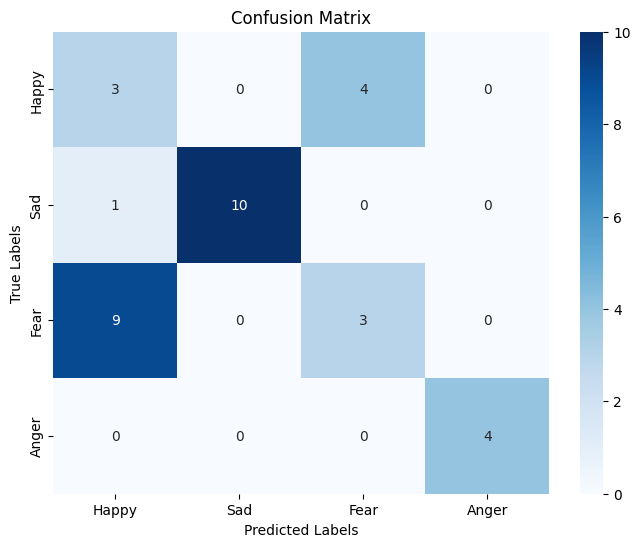

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# # Initialize the model again (with the same architecture)
# model = ImprovedEmotionTransformer().to(device)

# # Load the saved state dict
# model_load_path = "/content/drive/MyDrive/moodify_emotion_transformer_might work.pth"
# model.load_state_dict(torch.load(model_load_path))
# model.eval()  # Set the model to evaluation mode
# print(f"Model loaded from {model_load_path}")

# Evaluate the model's performance
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)
        outputs = model(x_feat)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred, target_names=INT_TO_LABEL.values()))

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=INT_TO_LABEL.values(), yticklabels=INT_TO_LABEL.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
MAPPED_LABELS = {
    "Amazement": "happy",
    "Solemnity": "fear",
    "Tenderness": "happy",
    "Nostalgia": "sad",
    "Calmness": "happy",
    "Power": "happy",
    "Joyful activation": "happy",
    "Tension": "anger",
    "Sadness": "sad"
}


In [ ]:
import pandas as pd

# Load the participant-level dataset
df = pd.read_csv("/content/drive/MyDrive/Moodify-CDS-2025/data (1).csv")
df
df = df.head(2688)
# df = df.iloc[2690:4726]
# df = df.iloc[4729:6552]
# df = df.iloc[6552::]
df

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother tongue
0,1,classical,0,1,0,0,0,0,1,1,0,3,1,0,21,1,English
1,1,classical,0,0,0,1,0,0,0,0,0,3,0,1,41,1,Dutch
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,0,24,1,English
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,0,32,0,Spanish
4,1,classical,0,0,0,1,1,0,0,0,0,4,0,1,21,0,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,100,classical,0,0,0,0,0,1,0,1,0,3,1,0,30,0,Dutch
2684,100,classical,0,1,0,0,0,0,0,1,1,1,1,0,33,0,Russian
2685,100,classical,0,0,0,0,0,1,0,0,1,4,1,0,23,1,English
2686,100,classical,1,1,0,0,0,1,0,0,0,3,0,0,22,0,Malay


In [ ]:
# Show the actual column names
print(df.columns.tolist())

# Clean column names: strip whitespace and lowercase everything
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df

['track id', ' genre', ' amazement', ' solemnity', ' tenderness', ' nostalgia', ' calmness', ' power', ' joyful_activation', ' tension', ' sadness', ' mood', ' liked', ' disliked', ' age', ' gender', ' mother tongue']


,track_id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother_tongue
0,1,classical,0,1,0,0,0,0,1,1,0,3,1,0,21,1,English
1,1,classical,0,0,0,1,0,0,0,0,0,3,0,1,41,1,Dutch
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,0,24,1,English
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,0,32,0,Spanish
4,1,classical,0,0,0,1,1,0,0,0,0,4,0,1,21,0,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,100,classical,0,0,0,0,0,1,0,1,0,3,1,0,30,0,Dutch
2684,100,classical,0,1,0,0,0,0,0,1,1,1,1,0,33,0,Russian
2685,100,classical,0,0,0,0,0,1,0,0,1,4,1,0,23,1,English
2686,100,classical,1,1,0,0,0,1,0,0,0,3,0,0,22,0,Malay


In [ ]:
emotion_cols = [
    "amazement", "solemnity", "tenderness", "nostalgia", "calmness",
    "power", "joyful_activation", "tension", "sadness"
]

avg_per_track = df.groupby('track_id')[emotion_cols].mean().reset_index()

In [ ]:
avg_per_track

,track_id,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness
0,1,0.145833,0.333333,0.208333,0.291667,0.625000,0.020833,0.083333,0.062500,0.312500
1,2,0.106383,0.170213,0.425532,0.340426,0.744681,0.042553,0.021277,0.021277,0.106383
2,3,0.173913,0.347826,0.130435,0.173913,0.065217,0.282609,0.413043,0.239130,0.152174
3,4,0.119048,0.142857,0.523810,0.452381,0.761905,0.023810,0.000000,0.023810,0.142857
4,5,0.045455,0.295455,0.318182,0.522727,0.318182,0.045455,0.068182,0.181818,0.318182
...,...,...,...,...,...,...,...,...,...,...
95,96,0.058824,0.176471,0.352941,0.294118,0.470588,0.058824,0.352941,0.058824,0.058824
96,97,0.117647,0.470588,0.058824,0.176471,0.235294,0.000000,0.000000,0.294118,0.352941
97,98,0.058824,0.411765,0.235294,0.352941,0.588235,0.000000,0.000000,0.058824,0.352941
98,99,0.117647,0.117647,0.411765,0.235294,0.882353,0.117647,0.176471,0.058824,0.176471


In [ ]:

emotion_to_main = {
    "amazement": "Happy",
    "solemnity": "Fear",
    "tenderness": "Happy",
    "nostalgia": "Sad",
    "calmness": "Happy",
    "power": "Happy",
    "joyful_activation": "Happy",
    "tension": "Anger",
    "sadness": "Sad"
}

# Function to find dominant emotion per track
def get_main_emotion(row):
    dominant_emotion = row[emotion_cols].idxmax()
    return emotion_to_main[dominant_emotion]

# Apply mapping
avg_per_track['Emotion'] = avg_per_track.apply(get_main_emotion, axis=1)


In [ ]:
print(avg_per_track.columns)


Index(['track_id', 'amazement', 'solemnity', 'tenderness', 'nostalgia',
       'calmness', 'power', 'joyful_activation', 'tension', 'sadness',
       'Emotion'],
      dtype='object')


In [ ]:
# Rename only if the column exists
if 'track_id' in avg_per_track.columns:
    formatted_df = avg_per_track[['track_id', 'Emotion']].copy()
    formatted_df = formatted_df.rename(columns={'track_id': 'Nro'})

    # Add placeholders for Album name, Track, Min:Sec
    formatted_df['Album name'] = 'Unknown Album'
    formatted_df['Track'] = 0
    formatted_df['Min:Sec'] = '00:00-00:00'

    # Reorder columns to match original format
    formatted_df = formatted_df[['Nro', 'Emotion', 'Album name', 'Track', 'Min:Sec']]
else:
    print("Column 'track id' not found in DataFrame.")

formatted_df
df=formatted_df
df

,Nro,Emotion,Album name,Track,Min:Sec
0,1,Happy,Unknown Album,0,00:00-00:00
1,2,Happy,Unknown Album,0,00:00-00:00
2,3,Happy,Unknown Album,0,00:00-00:00
3,4,Happy,Unknown Album,0,00:00-00:00
4,5,Sad,Unknown Album,0,00:00-00:00
...,...,...,...,...,...
95,96,Happy,Unknown Album,0,00:00-00:00
96,97,Fear,Unknown Album,0,00:00-00:00
97,98,Happy,Unknown Album,0,00:00-00:00
98,99,Happy,Unknown Album,0,00:00-00:00


In [ ]:
df['Nro'] = df['Nro'] +400

In [ ]:
df

,Nro,Emotion,Album name,Track,Min:Sec
0,401,Happy,Unknown Album,0,00:00-00:00
1,402,Happy,Unknown Album,0,00:00-00:00
2,403,Happy,Unknown Album,0,00:00-00:00
3,404,Happy,Unknown Album,0,00:00-00:00
4,405,Sad,Unknown Album,0,00:00-00:00
...,...,...,...,...,...
95,496,Happy,Unknown Album,0,00:00-00:00
96,497,Fear,Unknown Album,0,00:00-00:00
97,498,Happy,Unknown Album,0,00:00-00:00
98,499,Happy,Unknown Album,0,00:00-00:00


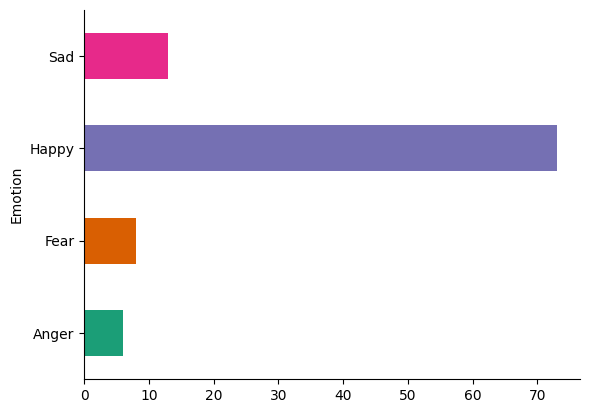

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
formatted_df.to_csv("aggregated_emotions_for_model_1.csv", index=False)

In [ ]:
# df=formatted_df

Epoch 1/30: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch [1/30], Loss: 6.1664, Accuracy: 0.2917


Epoch 2/30: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Epoch [2/30], Loss: 3.5710, Accuracy: 0.5833


Epoch 3/30: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch [3/30], Loss: 4.3571, Accuracy: 0.5000


Epoch 4/30: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Epoch [4/30], Loss: 4.2318, Accuracy: 0.4167


Epoch 5/30: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Epoch [5/30], Loss: 2.6640, Accuracy: 0.5833


Epoch 6/30: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch [6/30], Loss: 3.0107, Accuracy: 0.5833


Epoch 7/30: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch [7/30], Loss: 2.5912, Accuracy: 0.6250


Epoch 8/30: 100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch [8/30], Loss: 1.6894, Accuracy: 0.6667


Epoch 9/30: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch [9/30], Loss: 1.8617, Accuracy: 0.7500


Epoch 10/30: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Epoch [10/30], Loss: 1.5876, Accuracy: 0.6667


Epoch 11/30: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


Epoch [11/30], Loss: 1.3603, Accuracy: 0.7917


Epoch 12/30: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Epoch [12/30], Loss: 1.0125, Accuracy: 0.7917


Epoch 13/30: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch [13/30], Loss: 0.7768, Accuracy: 0.7917


Epoch 14/30: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch [14/30], Loss: 1.2083, Accuracy: 0.6250


Epoch 15/30: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch [15/30], Loss: 0.8456, Accuracy: 0.7917


Epoch 16/30: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch [16/30], Loss: 1.0543, Accuracy: 0.5417


Epoch 17/30: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch [17/30], Loss: 0.7651, Accuracy: 0.7083


Epoch 18/30: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


Epoch [18/30], Loss: 0.3746, Accuracy: 0.7917


Epoch 19/30: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Epoch [19/30], Loss: 0.1973, Accuracy: 0.9167


Epoch 20/30: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch [20/30], Loss: 0.2340, Accuracy: 0.8750


Epoch 21/30: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch [21/30], Loss: 0.6965, Accuracy: 0.7500


Epoch 22/30: 100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch [22/30], Loss: 0.3443, Accuracy: 0.8750


Epoch 23/30: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch [23/30], Loss: 0.1363, Accuracy: 0.9583


Epoch 24/30: 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


Epoch [24/30], Loss: 0.1982, Accuracy: 0.9583


Epoch 25/30: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Epoch [25/30], Loss: 0.2561, Accuracy: 0.9167


Epoch 26/30: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch [26/30], Loss: 0.2053, Accuracy: 0.9167


Epoch 27/30: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Epoch [27/30], Loss: 0.1840, Accuracy: 0.9583


Epoch 28/30: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch [28/30], Loss: 0.1706, Accuracy: 0.9583


Epoch 29/30: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch [29/30], Loss: 0.1405, Accuracy: 0.9583


Epoch 30/30: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]

Epoch [30/30], Loss: 0.2403, Accuracy: 0.9583


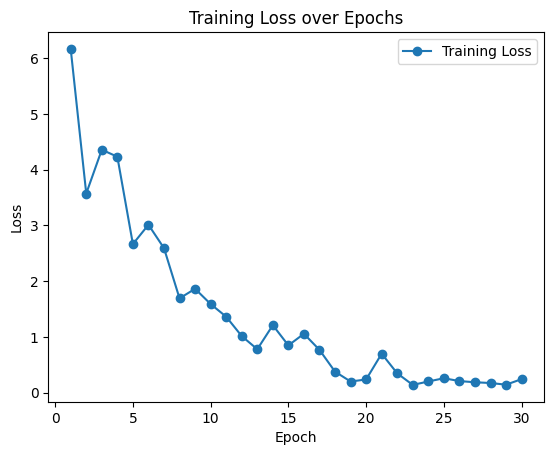

In [ ]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants (you can modify these based on your setup)
TARGET_SAMPLE_RATE = 44110  # Set the target sample rate
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}
csv_file_path="/content/aggregated_emotions_for_model_1.csv"
audio_folder_path = "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/classical"  # Update with the correct path if needed
audio_files = [f for f in os.listdir(audio_folder_path) if f.endswith('.mp3')]  # assuming .wav files

# Feature extraction class
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )
        self.norm = lambda x: torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))

    def forward(self, x):
        # Ensure that the MelSpectrogram transform is on the same device as the input tensor
        self.melspec = self.melspec.to(x.device)
        x = self.melspec(x)
        x = self.norm(x)
        return x

# Stereo to Mono class (for 2-channel audio files)
class Stereo2Mono(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.tensor([0.5, 0.5], requires_grad=False).view(2, 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            return torch.sum(waveform * self.weights, dim=0) * np.sqrt(2)
        return waveform
class EmotionDataset(Dataset):
    def __init__(self, audio_folder, csv_path, target_length=1280):
        self.audio_folder = audio_folder
        self.target_length = target_length

        # Load CSV
        df = pd.read_csv(csv_path)  # Use appropriate separator if not tab
        df = df[df["Emotion"].isin(LABEL_TO_INT.keys())]

        # Group by emotion
        grouped = df.groupby("Emotion")

        # Find the smallest group size
        min_size = min(len(group) for _, group in grouped)

        # Balance the dataset by sampling min_size from each class
        balanced_df = pd.concat([group.sample(n=min_size, random_state=42) for _, group in grouped])

        # Shuffle the result
        self.df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        nro = row['Nro']
        emotion = row['Emotion']
        label = LABEL_TO_INT[emotion]

        # Load audio
        audio_path = os.path.join(self.audio_folder, f"{nro}.mp3")
        waveform, sr = torchaudio.load(audio_path)

        # Resample if needed
        if sr != TARGET_SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SAMPLE_RATE)
            waveform = resampler(waveform)

        # Convert stereo to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Compute Mel spectrogram
        melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )(waveform)
        melspec = librosa.power_to_db(melspec.squeeze(0).numpy(), ref=np.max)
        melspec = torch.tensor(melspec)

        # Pad/crop to fixed length
        if melspec.shape[1] < self.target_length:
            pad = self.target_length - melspec.shape[1]
            melspec = torch.nn.functional.pad(melspec, (0, pad))
        else:
            melspec = melspec[:, :self.target_length]

        return melspec, label


# Model definition (Assumed already defined and loaded)

# Training parameters
num_epochs = 30
batch_size = 4
learning_rate = 1e-4

# Calculate the maximum length for padding (optional: can be done dynamically)
max_length = 0
for audio_file in os.listdir(audio_folder_path):
    audio_path = os.path.join(audio_folder_path, audio_file)
    waveform, sr = torchaudio.load(audio_path, format="mp3")
    features = FeatureExtractor()(waveform)
    max_length = max(max_length, features.size(1))  # Get the maximum length in the time dimension

# Initialize dataset and data loader
train_dataset = EmotionDataset(audio_folder_path, csv_file_path, target_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Removed collate_fn

# Define the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ImprovedEmotionTransformer().to(device)

# Load the saved state dict
# model_load_path = "/content/drive/MyDrive/moodify_emotion_transformer.pth"
# model.load_state_dict(torch.load(model_load_path))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = model(features)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * features.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot training loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()




In [ ]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants (you can modify these based on your setup)
TARGET_SAMPLE_RATE = 44110  # Set the target sample rate
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}
csv_file_path="/content/aggregated_emotions_for_model_2.csv"
audio_folder_path = "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/rock"  # Update with the correct path if needed
audio_files = [f for f in os.listdir(audio_folder_path) if f.endswith('.mp3')]  # assuming .wav files

# Feature extraction class
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )
        self.norm = lambda x: torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))

    def forward(self, x):
        # Ensure that the MelSpectrogram transform is on the same device as the input tensor
        self.melspec = self.melspec.to(x.device)
        x = self.melspec(x)
        x = self.norm(x)
        return x

# Stereo to Mono class (for 2-channel audio files)
class Stereo2Mono(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.tensor([0.5, 0.5], requires_grad=False).view(2, 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            return torch.sum(waveform * self.weights, dim=0) * np.sqrt(2)
        return waveform
class EmotionDataset(Dataset):
    def __init__(self, audio_folder, csv_path, target_length=1280):
        self.audio_folder = audio_folder
        self.target_length = target_length

        # Load CSV
        df = pd.read_csv(csv_path)  # Use appropriate separator if not tab
        df = df[df["Emotion"].isin(LABEL_TO_INT.keys())]

        # Group by emotion
        grouped = df.groupby("Emotion")

        # Find the smallest group size
        min_size = min(len(group) for _, group in grouped)

        # Balance the dataset by sampling min_size from each class
        balanced_df = pd.concat([group.sample(n=min_size, random_state=42) for _, group in grouped])

        # Shuffle the result
        self.df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        nro = row['Nro']
        emotion = row['Emotion']
        label = LABEL_TO_INT[emotion]

        # Load audio
        audio_path = os.path.join(self.audio_folder, f"{nro}.mp3")
        waveform, sr = torchaudio.load(audio_path)

        # Resample if needed
        if sr != TARGET_SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SAMPLE_RATE)
            waveform = resampler(waveform)

        # Convert stereo to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Compute Mel spectrogram
        melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )(waveform)
        melspec = librosa.power_to_db(melspec.squeeze(0).numpy(), ref=np.max)
        melspec = torch.tensor(melspec)

        # Pad/crop to fixed length
        if melspec.shape[1] < self.target_length:
            pad = self.target_length - melspec.shape[1]
            melspec = torch.nn.functional.pad(melspec, (0, pad))
        else:
            melspec = melspec[:, :self.target_length]

        return melspec, label


# Model definition (Assumed already defined and loaded)

# Training parameters
# num_epochs = 50
# batch_size = 16
# learning_rate = 1e-4

# Calculate the maximum length for padding (optional: can be done dynamically)
max_length = 0
for audio_file in os.listdir(audio_folder_path):
    audio_path = os.path.join(audio_folder_path, audio_file)
    waveform, sr = torchaudio.load(audio_path, format="mp3")
    features = FeatureExtractor()(waveform)
    max_length = max(max_length, features.size(1))  # Get the maximum length in the time dimension

# Initialize dataset and data loader
train_dataset = EmotionDataset(audio_folder_path, csv_file_path, target_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Removed collate_fn

# Define the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ImprovedEmotionTransformer().to(device)

# # Load the saved state dict
# model_load_path = "/content/drive/MyDrive/moodify_emotion_transformer.pth"
# model.load_state_dict(torch.load(model_load_path))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = model(features)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * features.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot training loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()




Epoch 1/30: 100%|██████████| 3/3 [00:07<00:00,  2.43s/it]


Epoch [1/30], Loss: 1.4303, Accuracy: 0.2500


Epoch 2/30: 100%|██████████| 3/3 [00:07<00:00,  2.60s/it]


Epoch [2/30], Loss: 1.4651, Accuracy: 0.4167


Epoch 3/30: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


Epoch [3/30], Loss: 1.5313, Accuracy: 0.1667


Epoch 4/30: 100%|██████████| 3/3 [00:07<00:00,  2.58s/it]


Epoch [4/30], Loss: 1.5593, Accuracy: 0.1667


Epoch 5/30: 100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


Epoch [5/30], Loss: 1.3942, Accuracy: 0.5000


Epoch 6/30: 100%|██████████| 3/3 [00:07<00:00,  2.41s/it]


Epoch [6/30], Loss: 1.5015, Accuracy: 0.1667


Epoch 7/30: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


Epoch [7/30], Loss: 1.3949, Accuracy: 0.2500


Epoch 8/30: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


Epoch [8/30], Loss: 1.5595, Accuracy: 0.0833


Epoch 9/30: 100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


Epoch [9/30], Loss: 1.5033, Accuracy: 0.1667


Epoch 10/30: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


Epoch [10/30], Loss: 1.6228, Accuracy: 0.0833


Epoch 11/30: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


Epoch [11/30], Loss: 1.5796, Accuracy: 0.1667


Epoch 12/30: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


Epoch [12/30], Loss: 1.3452, Accuracy: 0.2500


Epoch 13/30: 100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


Epoch [13/30], Loss: 1.5012, Accuracy: 0.1667


Epoch 14/30:  67%|██████▋   | 2/3 [00:05<00:02,  2.91s/it]


KeyboardInterrupt: 

In [ ]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants (you can modify these based on your setup)
TARGET_SAMPLE_RATE = 44110  # Set the target sample rate
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}
csv_file_path="/content/aggregated_emotions_for_model_3.csv"
audio_folder_path = "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/electronic"  # Update with the correct path if needed
audio_files = [f for f in os.listdir(audio_folder_path) if f.endswith('.mp3')]  # assuming .wav files

# Feature extraction class
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )
        self.norm = lambda x: torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))

    def forward(self, x):
        # Ensure that the MelSpectrogram transform is on the same device as the input tensor
        self.melspec = self.melspec.to(x.device)
        x = self.melspec(x)
        x = self.norm(x)
        return x

# Stereo to Mono class (for 2-channel audio files)
class Stereo2Mono(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.tensor([0.5, 0.5], requires_grad=False).view(2, 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            return torch.sum(waveform * self.weights, dim=0) * np.sqrt(2)
        return waveform
class EmotionDataset(Dataset):
    def __init__(self, audio_folder, csv_path, target_length=1280):
        self.audio_folder = audio_folder
        self.target_length = target_length

        # Load CSV
        df = pd.read_csv(csv_path)  # Use appropriate separator if not tab
        df = df[df["Emotion"].isin(LABEL_TO_INT.keys())]

        # Group by emotion
        grouped = df.groupby("Emotion")

        # Find the smallest group size
        min_size = min(len(group) for _, group in grouped)

        # Balance the dataset by sampling min_size from each class
        balanced_df = pd.concat([group.sample(n=min_size, random_state=42) for _, group in grouped])

        # Shuffle the result
        self.df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        nro = row['Nro']
        emotion = row['Emotion']
        label = LABEL_TO_INT[emotion]

        # Load audio
        audio_path = os.path.join(self.audio_folder, f"{nro}.mp3")
        waveform, sr = torchaudio.load(audio_path)

        # Resample if needed
        if sr != TARGET_SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SAMPLE_RATE)
            waveform = resampler(waveform)

        # Convert stereo to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Compute Mel spectrogram
        melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )(waveform)
        melspec = librosa.power_to_db(melspec.squeeze(0).numpy(), ref=np.max)
        melspec = torch.tensor(melspec)

        # Pad/crop to fixed length
        if melspec.shape[1] < self.target_length:
            pad = self.target_length - melspec.shape[1]
            melspec = torch.nn.functional.pad(melspec, (0, pad))
        else:
            melspec = melspec[:, :self.target_length]

        return melspec, label


# Model definition (Assumed already defined and loaded)

# Training parameters
# num_epochs = 50
# batch_size = 16
# learning_rate = 1e-4

# Calculate the maximum length for padding (optional: can be done dynamically)
max_length = 0
for audio_file in os.listdir(audio_folder_path):
    audio_path = os.path.join(audio_folder_path, audio_file)
    waveform, sr = torchaudio.load(audio_path, format="mp3")
    features = FeatureExtractor()(waveform)
    max_length = max(max_length, features.size(1))  # Get the maximum length in the time dimension

# Initialize dataset and data loader
train_dataset = EmotionDataset(audio_folder_path, csv_file_path, target_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Removed collate_fn

# Define the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ImprovedEmotionTransformer().to(device)

# # Load the saved state dict
# model_load_path = "/content/drive/MyDrive/moodify_emotion_transformer.pth"
# model.load_state_dict(torch.load(model_load_path))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = model(features)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * features.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot training loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()



Epoch 1/30: 100%|██████████| 2/2 [00:09<00:00,  4.84s/it]


Epoch [1/30], Loss: 0.0942, Accuracy: 0.9375


Epoch 2/30: 100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


Epoch [2/30], Loss: 0.1946, Accuracy: 0.8750


Epoch 3/30: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Epoch [3/30], Loss: 0.2713, Accuracy: 0.9375


Epoch 4/30: 100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Epoch [4/30], Loss: 0.1290, Accuracy: 0.9375


Epoch 5/30: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Epoch [5/30], Loss: 0.1816, Accuracy: 0.9375


Epoch 6/30: 100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Epoch [6/30], Loss: 0.1545, Accuracy: 0.9375


Epoch 7/30: 100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


Epoch [7/30], Loss: 0.1052, Accuracy: 0.9375


Epoch 8/30: 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Epoch [8/30], Loss: 0.2065, Accuracy: 0.8750


Epoch 9/30: 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Epoch [9/30], Loss: 0.2243, Accuracy: 0.9375


Epoch 10/30: 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Epoch [10/30], Loss: 0.1477, Accuracy: 1.0000


Epoch 11/30: 100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


Epoch [11/30], Loss: 0.1935, Accuracy: 0.8750


Epoch 12/30: 100%|██████████| 2/2 [00:09<00:00,  4.84s/it]


Epoch [12/30], Loss: 0.1699, Accuracy: 0.9375


Epoch 13/30: 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Epoch [13/30], Loss: 0.2050, Accuracy: 0.8750


Epoch 14/30: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Epoch [14/30], Loss: 0.1538, Accuracy: 0.9375


Epoch 15/30: 100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Epoch [15/30], Loss: 0.1542, Accuracy: 0.9375


Epoch 16/30: 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


Epoch [16/30], Loss: 0.1390, Accuracy: 0.9375


Epoch 17/30: 100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Epoch [17/30], Loss: 0.1867, Accuracy: 0.8750


Epoch 18/30: 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Epoch [18/30], Loss: 0.1032, Accuracy: 0.9375


Epoch 19/30: 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Epoch [19/30], Loss: 0.2164, Accuracy: 0.9375


Epoch 20/30: 100%|██████████| 2/2 [00:09<00:00,  4.84s/it]


Epoch [20/30], Loss: 0.0612, Accuracy: 1.0000


Epoch 21/30: 100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Epoch [21/30], Loss: 0.1040, Accuracy: 0.9375


Epoch 22/30: 100%|██████████| 2/2 [00:09<00:00,  4.97s/it]


Epoch [22/30], Loss: 0.0659, Accuracy: 1.0000


Epoch 23/30: 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Epoch [23/30], Loss: 0.1382, Accuracy: 0.9375


Epoch 24/30: 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Epoch [24/30], Loss: 0.1068, Accuracy: 1.0000


Epoch 25/30: 100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Epoch [25/30], Loss: 0.1056, Accuracy: 0.9375


Epoch 26/30: 100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Epoch [26/30], Loss: 0.1670, Accuracy: 0.9375


Epoch 27/30: 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Epoch [27/30], Loss: 0.1455, Accuracy: 0.9375


Epoch 28/30: 100%|██████████| 2/2 [00:09<00:00,  4.92s/it]


Epoch [28/30], Loss: 0.1453, Accuracy: 0.9375


Epoch 29/30: 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Epoch [29/30], Loss: 0.0858, Accuracy: 0.9375


Epoch 30/30: 100%|██████████| 2/2 [00:09<00:00,  4.80s/it]

Epoch [30/30], Loss: 0.1402, Accuracy: 0.9375


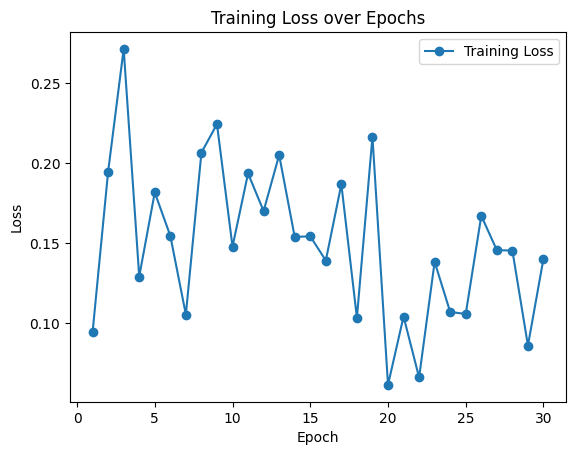

In [ ]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants (you can modify these based on your setup)
TARGET_SAMPLE_RATE = 44110  # Set the target sample rate
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}
csv_file_path="/content/aggregated_emotions_for_model_4.csv"
audio_folder_path = "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/pop"  # Update with the correct path if needed
audio_files = [f for f in os.listdir(audio_folder_path) if f.endswith('.mp3')]  # assuming .wav files

# Feature extraction class
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )
        self.norm = lambda x: torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))

    def forward(self, x):
        # Ensure that the MelSpectrogram transform is on the same device as the input tensor
        self.melspec = self.melspec.to(x.device)
        x = self.melspec(x)
        x = self.norm(x)
        return x

# Stereo to Mono class (for 2-channel audio files)
class Stereo2Mono(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.tensor([0.5, 0.5], requires_grad=False).view(2, 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            return torch.sum(waveform * self.weights, dim=0) * np.sqrt(2)
        return waveform
class EmotionDataset(Dataset):
    def __init__(self, audio_folder, csv_path, target_length=1280):
        self.audio_folder = audio_folder
        self.target_length = target_length

        # Load CSV
        df = pd.read_csv(csv_path)  # Use appropriate separator if not tab
        df = df[df["Emotion"].isin(LABEL_TO_INT.keys())]

        # Group by emotion
        grouped = df.groupby("Emotion")

        # Find the smallest group size
        min_size = min(len(group) for _, group in grouped)

        # Balance the dataset by sampling min_size from each class
        balanced_df = pd.concat([group.sample(n=min_size, random_state=42) for _, group in grouped])

        # Shuffle the result
        self.df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        nro = row['Nro']
        emotion = row['Emotion']
        label = LABEL_TO_INT[emotion]

        # Load audio
        audio_path = os.path.join(self.audio_folder, f"{nro}.mp3")
        waveform, sr = torchaudio.load(audio_path)

        # Resample if needed
        if sr != TARGET_SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SAMPLE_RATE)
            waveform = resampler(waveform)

        # Convert stereo to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Compute Mel spectrogram
        melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )(waveform)
        melspec = librosa.power_to_db(melspec.squeeze(0).numpy(), ref=np.max)
        melspec = torch.tensor(melspec)

        # Pad/crop to fixed length
        if melspec.shape[1] < self.target_length:
            pad = self.target_length - melspec.shape[1]
            melspec = torch.nn.functional.pad(melspec, (0, pad))
        else:
            melspec = melspec[:, :self.target_length]

        return melspec, label


# Model definition (Assumed already defined and loaded)

# Training parameters
num_epochs = 30
batch_size = 8
learning_rate = 1e-6

# Calculate the maximum length for padding (optional: can be done dynamically)
max_length = 0
for audio_file in os.listdir(audio_folder_path):
    audio_path = os.path.join(audio_folder_path, audio_file)
    waveform, sr = torchaudio.load(audio_path, format="mp3")
    features = FeatureExtractor()(waveform)
    max_length = max(max_length, features.size(1))  # Get the maximum length in the time dimension

# Initialize dataset and data loader
train_dataset = EmotionDataset(audio_folder_path, csv_file_path, target_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Removed collate_fn

# Define the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ImprovedEmotionTransformer().to(device)

# # Load the saved state dict
# model_load_path = "/content/drive/MyDrive/moodify_emotion_transformer.pth"
# model.load_state_dict(torch.load(model_load_path))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = model(features)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * features.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot training loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()



In [ ]:
import os
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# Constants (from training code)
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}

csv_path="/content/aggregated_emotions_for_model_1.csv"
df = pd.read_csv(csv_path)  # Use appropriate separator if not tab
df = df[df["Emotion"].isin(LABEL_TO_INT.keys())]

        # Group by emotion
grouped = df.groupby("Emotion")
# Find the smallest group size
min_size = min(len(group) for _, group in grouped)
# Balance the dataset by sampling min_size from each class
balanced_df = pd.concat([group.sample(n=min_size, random_state=42) for _, group in grouped])
df=balanced_df
print(df)
# Assuming these classes and functions are already defined
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )
        self.norm = lambda x: torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))

    def forward(self, x):
        x = self.melspec(x)
        x = self.norm(x)
        return x

class Stereo2Mono(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.tensor([0.5, 0.5], requires_grad=False).view(2, 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            return torch.sum(waveform * self.weights, dim=0) * np.sqrt(2)
        return waveform

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ImprovedEmotionTransformer().to(device)

# # Load the saved model state
# model_load_path = "/content/drive/MyDrive/moodify_emotion_transformer.pth"
# model.load_state_dict(torch.load(model_load_path))
# model.eval()  # Set the model to evaluation mode
# print(f"Model loaded from {model_load_path}")
# print(model)

# Define the feature extractor
extractor = FeatureExtractor().to(device)

# Evaluate the model on the audio files in the emotionmusicimport folder
audio_folder_path = "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/classical"  # Update with the correct path if needed
audio_files = [f for f in os.listdir(audio_folder_path) if f.endswith('.mp3')]  # assuming .wav files

y_true, y_pred = [], []

def extract_features(audio_path):
    waveform, sr = torchaudio.load(audio_path, format="mp3")  # Explicitly specify mp3 format
    if sr != TARGET_SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, TARGET_SAMPLE_RATE)(waveform)
    mono_wf = Stereo2Mono()(waveform)

    # Move the waveform to the device (e.g., GPU)
    mono_wf = mono_wf.to(device)

    features = extractor(mono_wf)
    return features

for audio_file in tqdm(audio_files, desc="Evaluating"):
    audio_path = os.path.join(audio_folder_path, audio_file)

    # Extract the numeric label (e.g., '1.mp3' -> '1')
    file_id = int(audio_file.split(".")[0])  # '1.mp3' -> 1

    # Retrieve the corresponding emotion from the CSV file based on the 'Nro' column
    label_row = df[df['Nro'] == file_id]  # Find the row where 'Nro' matches the filename
    if not label_row.empty:

        label_str = label_row['Emotion'].values[0]  # Get the emotion label from the 'Emotion' column
        print(label_str)
        label = LABEL_TO_INT.get(label_str, -1)  # Map the emotion to an integer using LABEL_TO_INT

    else:
        print(f"Warning: No label found for file {audio_file}")
        continue  # Skip this file if no matching label is found

    y_true.append(label)

    # Extract features from the audio file
    features = extract_features(audio_path).to(device)

    # Make a prediction with the trained model
    with torch.no_grad():
        outputs = model(features.unsqueeze(0))  # Add batch dimension
        preds = torch.argmax(outputs, dim=1)

    y_pred.append(preds.item())  # Store the prediction


print(f"Unique predicted labels: {set(y_true)}")
# Print classification report
# print(INT_TO_LABEL.values)
target_names = list(LABEL_TO_INT.keys())
print(target_names)

print(f"Unique predicted labels: {set(y_pred)}")

print(classification_report(y_true, y_pred, target_names=target_names))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=INT_TO_LABEL.values(), yticklabels=INT_TO_LABEL.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


    Nro Emotion     Album name  Track      Min:Sec
52  453   Anger  Unknown Album      0  00:00-00:00
65  466   Anger  Unknown Album      0  00:00-00:00
85  486   Anger  Unknown Album      0  00:00-00:00
73  474   Anger  Unknown Album      0  00:00-00:00
75  476   Anger  Unknown Album      0  00:00-00:00
74  475   Anger  Unknown Album      0  00:00-00:00
40  441    Fear  Unknown Album      0  00:00-00:00
83  484    Fear  Unknown Album      0  00:00-00:00
24  425    Fear  Unknown Album      0  00:00-00:00
96  497    Fear  Unknown Album      0  00:00-00:00
47  448    Fear  Unknown Album      0  00:00-00:00
71  472    Fear  Unknown Album      0  00:00-00:00
5   406   Happy  Unknown Album      0  00:00-00:00
87  488   Happy  Unknown Album      0  00:00-00:00
22  423   Happy  Unknown Album      0  00:00-00:00
0   401   Happy  Unknown Album      0  00:00-00:00
34  435   Happy  Unknown Album      0  00:00-00:00
99  500   Happy  Unknown Album      0  00:00-00:00
82  483     Sad  Unknown Album 

Evaluating: 100%|██████████| 100/100 [00:00<00:00, 3723.83it/s]

Unique predicted labels: set()
['Happy', 'Sad', 'Fear', 'Anger']
Unique predicted labels: set()


ValueError: Number of classes, 0, does not match size of target_names, 4. Try specifying the labels parameter

In [ ]:
# Save the model
model_save_path = "/content/drive/MyDrive/balanced2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/balanced2.pth


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
TARGET_SAMPLE_RATE = 44100
TARGET_AUDIO_LENGTH = 15 * TARGET_SAMPLE_RATE
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}
desired_emotions = list(LABEL_TO_INT.keys())

# Load and combine datasets
def load_dataset(csv_path, audio_dir):
    df = pd.read_csv(csv_path)
    df["Emotion"] = df["Emotion"].str.capitalize()
    df = df[df["Emotion"].isin(desired_emotions)].reset_index(drop=True)
    df["File"] = df["Nro"].astype(str).str.zfill(3) + ".mp3"
    df["DataDir"] = audio_dir
    return df

df1 = load_dataset("/content/drive/MyDrive/Moodify-CDS-2025/data/set1_tracklist.csv", "/content/drive/MyDrive/Moodify-CDS-2025/data/Set1")
df2 = load_dataset("/content/aggregated_emotions_for_model_1.csv", "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/classical")
df_combined = pd.concat([df1, df2]).reset_index(drop=True)

# Collate Function
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = pad_sequence(waveforms, batch_first=True)
    labels = torch.tensor(labels)
    return waveforms, labels

# Audio preprocessing
class Stereo2Mono(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.tensor([0.5, 0.5], requires_grad=False).view(2, 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            return torch.sum(waveform * self.weights, dim=0) * np.sqrt(2)
        return waveform

def path_to_waveform_tensor(path: str, sample_rate=TARGET_SAMPLE_RATE):
    waveform, sr = torchaudio.load(path)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    mono_wf = Stereo2Mono()(waveform)
    return mono_wf.squeeze(0).cpu()

def split_waveform_segments(wf: torch.Tensor, target_len=TARGET_AUDIO_LENGTH, min_length: int=TARGET_SAMPLE_RATE * 10, train: bool=False):
    wf_len = wf.shape[0]
    if wf_len < target_len:
        return [wf.detach().clone()] if wf_len >= min_length else []
    else:
        hop_length = target_len // 2 if train else target_len
        segments = []
        for i in range(0, wf_len, hop_length):
            if wf_len - i > target_len:
                segments.append(wf[i:i+target_len])
            elif wf_len - i >= min_length:
                segments.append(wf[-target_len if train else i:])
        return segments

# Dataset
class AudioEmotionDataset(Dataset):
    def __init__(self, dataframe, train=True):
        self.dataframe = dataframe
        self.train = train
        self.data = []
        self.labels = []
        self.prepare_dataset()

    def prepare_dataset(self):
        for _, row in tqdm(self.dataframe.iterrows(), total=len(self.dataframe)):
            audio_path = os.path.join(row["DataDir"], row["File"])
            label = LABEL_TO_INT[row["Emotion"]]
            try:
                wf = path_to_waveform_tensor(audio_path)
                segments = split_waveform_segments(wf, train=self.train)
                self.data.extend(segments)
                self.labels.extend([label] * len(segments))
            except Exception as e:
                print(f"Error loading {audio_path}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

# Feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True
        )
        self.norm = lambda x: torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))

    def forward(self, x):
        x = self.melspec(x)
        x = self.norm(x)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer model
class ImprovedEmotionTransformer(nn.Module):
    def __init__(self, input_dim=128, num_classes=4, d_model=128, nhead=4, num_layers=4, dropout=0.75):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)               # (B, T, F)
        x = self.input_proj(x)               # (B, T, D)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)               # (T, B, D)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)                    # (B, D)
        x = self.dropout(x)
        return self.fc_out(x)

# Prepare datasets
full_dataset = AudioEmotionDataset(df_combined, train=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)

# Initialize model
extractor = FeatureExtractor().to(device)
# model = ImprovedEmotionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-9)

# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)

        optimizer.zero_grad()
        outputs = model(x_feat)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)
        outputs = model(x_feat)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=INT_TO_LABEL.values()))



100%|██████████| 220/220 [00:05<00:00, 40.83it/s] 


Error loading /content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/classical/401.mp3: Failed to open the input "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/classical/401.mp3" (No such file or directory).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7c876536c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7c8765315a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x7c879cba9034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::

Epoch 1/300: 100%|██████████| 9/9 [00:00<00:00, 21.99it/s]


Epoch 1/300, Loss: 0.2463


Epoch 2/300: 100%|██████████| 9/9 [00:00<00:00, 22.41it/s]


Epoch 2/300, Loss: 0.3088


Epoch 3/300: 100%|██████████| 9/9 [00:00<00:00, 22.62it/s]


Epoch 3/300, Loss: 0.2214


Epoch 4/300: 100%|██████████| 9/9 [00:00<00:00, 22.39it/s]


Epoch 4/300, Loss: 0.1625


Epoch 5/300: 100%|██████████| 9/9 [00:00<00:00, 22.19it/s]


Epoch 5/300, Loss: 0.2178


Epoch 6/300: 100%|██████████| 9/9 [00:00<00:00, 22.53it/s]


Epoch 6/300, Loss: 0.1730


Epoch 7/300: 100%|██████████| 9/9 [00:00<00:00, 21.93it/s]


Epoch 7/300, Loss: 0.2983


Epoch 8/300: 100%|██████████| 9/9 [00:00<00:00, 21.66it/s]


Epoch 8/300, Loss: 0.2685


Epoch 9/300: 100%|██████████| 9/9 [00:00<00:00, 21.45it/s]


Epoch 9/300, Loss: 0.2100


Epoch 10/300: 100%|██████████| 9/9 [00:00<00:00, 21.79it/s]


Epoch 10/300, Loss: 0.2055


Epoch 11/300: 100%|██████████| 9/9 [00:00<00:00, 21.31it/s]


Epoch 11/300, Loss: 0.2223


Epoch 12/300: 100%|██████████| 9/9 [00:00<00:00, 22.05it/s]


Epoch 12/300, Loss: 0.2488


Epoch 13/300: 100%|██████████| 9/9 [00:00<00:00, 22.16it/s]


Epoch 13/300, Loss: 0.2028


Epoch 14/300: 100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


Epoch 14/300, Loss: 0.2519


Epoch 15/300: 100%|██████████| 9/9 [00:00<00:00, 22.36it/s]


Epoch 15/300, Loss: 0.2490


Epoch 16/300: 100%|██████████| 9/9 [00:00<00:00, 21.74it/s]


Epoch 16/300, Loss: 0.2243


Epoch 17/300: 100%|██████████| 9/9 [00:00<00:00, 21.91it/s]


Epoch 17/300, Loss: 0.2298


Epoch 18/300: 100%|██████████| 9/9 [00:00<00:00, 21.62it/s]


Epoch 18/300, Loss: 0.2295


Epoch 19/300: 100%|██████████| 9/9 [00:00<00:00, 22.12it/s]


Epoch 19/300, Loss: 0.2463


Epoch 20/300: 100%|██████████| 9/9 [00:00<00:00, 21.68it/s]


Epoch 20/300, Loss: 0.2488


Epoch 21/300: 100%|██████████| 9/9 [00:00<00:00, 22.81it/s]


Epoch 21/300, Loss: 0.2648


Epoch 22/300: 100%|██████████| 9/9 [00:00<00:00, 21.87it/s]


Epoch 22/300, Loss: 0.2072


Epoch 23/300: 100%|██████████| 9/9 [00:00<00:00, 21.80it/s]


Epoch 23/300, Loss: 0.2292


Epoch 24/300: 100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


Epoch 24/300, Loss: 0.2156


Epoch 25/300: 100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


Epoch 25/300, Loss: 0.2746


Epoch 26/300: 100%|██████████| 9/9 [00:00<00:00, 22.27it/s]


Epoch 26/300, Loss: 0.2568


Epoch 27/300: 100%|██████████| 9/9 [00:00<00:00, 22.15it/s]


Epoch 27/300, Loss: 0.2260


Epoch 28/300: 100%|██████████| 9/9 [00:00<00:00, 22.36it/s]


Epoch 28/300, Loss: 0.2794


Epoch 29/300: 100%|██████████| 9/9 [00:00<00:00, 21.99it/s]


Epoch 29/300, Loss: 0.2618


Epoch 30/300: 100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


Epoch 30/300, Loss: 0.2399


Epoch 31/300: 100%|██████████| 9/9 [00:00<00:00, 21.78it/s]


Epoch 31/300, Loss: 0.1858


Epoch 32/300: 100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


Epoch 32/300, Loss: 0.2163


Epoch 33/300: 100%|██████████| 9/9 [00:00<00:00, 22.15it/s]


Epoch 33/300, Loss: 0.2395


Epoch 34/300: 100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


Epoch 34/300, Loss: 0.1795


Epoch 35/300: 100%|██████████| 9/9 [00:00<00:00, 22.11it/s]


Epoch 35/300, Loss: 0.3269


Epoch 36/300: 100%|██████████| 9/9 [00:00<00:00, 21.75it/s]


Epoch 36/300, Loss: 0.3073


Epoch 37/300: 100%|██████████| 9/9 [00:00<00:00, 21.45it/s]


Epoch 37/300, Loss: 0.3119


Epoch 38/300: 100%|██████████| 9/9 [00:00<00:00, 21.91it/s]


Epoch 38/300, Loss: 0.2883


Epoch 39/300: 100%|██████████| 9/9 [00:00<00:00, 22.27it/s]


Epoch 39/300, Loss: 0.2337


Epoch 40/300: 100%|██████████| 9/9 [00:00<00:00, 21.26it/s]


Epoch 40/300, Loss: 0.2586


Epoch 41/300: 100%|██████████| 9/9 [00:00<00:00, 21.61it/s]


Epoch 41/300, Loss: 0.2537


Epoch 42/300: 100%|██████████| 9/9 [00:00<00:00, 22.65it/s]


Epoch 42/300, Loss: 0.3030


Epoch 43/300: 100%|██████████| 9/9 [00:00<00:00, 22.64it/s]


Epoch 43/300, Loss: 0.1744


Epoch 44/300: 100%|██████████| 9/9 [00:00<00:00, 22.08it/s]


Epoch 44/300, Loss: 0.2215


Epoch 45/300: 100%|██████████| 9/9 [00:00<00:00, 21.97it/s]


Epoch 45/300, Loss: 0.2493


Epoch 46/300: 100%|██████████| 9/9 [00:00<00:00, 22.41it/s]


Epoch 46/300, Loss: 0.2182


Epoch 47/300: 100%|██████████| 9/9 [00:00<00:00, 22.97it/s]


Epoch 47/300, Loss: 0.2157


Epoch 48/300: 100%|██████████| 9/9 [00:00<00:00, 22.35it/s]


Epoch 48/300, Loss: 0.2032


Epoch 49/300: 100%|██████████| 9/9 [00:00<00:00, 21.84it/s]


Epoch 49/300, Loss: 0.2560


Epoch 50/300: 100%|██████████| 9/9 [00:00<00:00, 21.90it/s]


Epoch 50/300, Loss: 0.1979


Epoch 51/300: 100%|██████████| 9/9 [00:00<00:00, 22.29it/s]


Epoch 51/300, Loss: 0.2357


Epoch 52/300: 100%|██████████| 9/9 [00:00<00:00, 22.06it/s]


Epoch 52/300, Loss: 0.2557


Epoch 53/300: 100%|██████████| 9/9 [00:00<00:00, 22.39it/s]


Epoch 53/300, Loss: 0.2055


Epoch 54/300: 100%|██████████| 9/9 [00:00<00:00, 21.68it/s]


Epoch 54/300, Loss: 0.2725


Epoch 55/300: 100%|██████████| 9/9 [00:00<00:00, 22.26it/s]


Epoch 55/300, Loss: 0.2071


Epoch 56/300: 100%|██████████| 9/9 [00:00<00:00, 21.83it/s]


Epoch 56/300, Loss: 0.2577


Epoch 57/300: 100%|██████████| 9/9 [00:00<00:00, 22.37it/s]


Epoch 57/300, Loss: 0.2869


Epoch 58/300: 100%|██████████| 9/9 [00:00<00:00, 21.94it/s]


Epoch 58/300, Loss: 0.2434


Epoch 59/300: 100%|██████████| 9/9 [00:00<00:00, 22.63it/s]


Epoch 59/300, Loss: 0.1871


Epoch 60/300: 100%|██████████| 9/9 [00:00<00:00, 21.87it/s]


Epoch 60/300, Loss: 0.2701


Epoch 61/300: 100%|██████████| 9/9 [00:00<00:00, 22.21it/s]


Epoch 61/300, Loss: 0.2464


Epoch 62/300: 100%|██████████| 9/9 [00:00<00:00, 21.72it/s]


Epoch 62/300, Loss: 0.2134


Epoch 63/300: 100%|██████████| 9/9 [00:00<00:00, 22.48it/s]


Epoch 63/300, Loss: 0.2222


Epoch 64/300: 100%|██████████| 9/9 [00:00<00:00, 22.06it/s]


Epoch 64/300, Loss: 0.2475


Epoch 65/300: 100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


Epoch 65/300, Loss: 0.2844


Epoch 66/300: 100%|██████████| 9/9 [00:00<00:00, 22.04it/s]


Epoch 66/300, Loss: 0.2031


Epoch 67/300: 100%|██████████| 9/9 [00:00<00:00, 21.78it/s]


Epoch 67/300, Loss: 0.2199


Epoch 68/300: 100%|██████████| 9/9 [00:00<00:00, 21.77it/s]


Epoch 68/300, Loss: 0.2243


Epoch 69/300: 100%|██████████| 9/9 [00:00<00:00, 22.00it/s]


Epoch 69/300, Loss: 0.1926


Epoch 70/300: 100%|██████████| 9/9 [00:00<00:00, 21.68it/s]


Epoch 70/300, Loss: 0.3210


Epoch 71/300: 100%|██████████| 9/9 [00:00<00:00, 22.38it/s]


Epoch 71/300, Loss: 0.2952


Epoch 72/300: 100%|██████████| 9/9 [00:00<00:00, 22.15it/s]


Epoch 72/300, Loss: 0.3116


Epoch 73/300: 100%|██████████| 9/9 [00:00<00:00, 22.40it/s]


Epoch 73/300, Loss: 0.2175


Epoch 74/300: 100%|██████████| 9/9 [00:00<00:00, 22.08it/s]


Epoch 74/300, Loss: 0.2610


Epoch 75/300: 100%|██████████| 9/9 [00:00<00:00, 22.23it/s]


Epoch 75/300, Loss: 0.1905


Epoch 76/300: 100%|██████████| 9/9 [00:00<00:00, 22.21it/s]


Epoch 76/300, Loss: 0.2057


Epoch 77/300: 100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


Epoch 77/300, Loss: 0.2067


Epoch 78/300: 100%|██████████| 9/9 [00:00<00:00, 21.86it/s]


Epoch 78/300, Loss: 0.2676


Epoch 79/300: 100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


Epoch 79/300, Loss: 0.1912


Epoch 80/300: 100%|██████████| 9/9 [00:00<00:00, 22.39it/s]


Epoch 80/300, Loss: 0.2945


Epoch 81/300: 100%|██████████| 9/9 [00:00<00:00, 22.48it/s]


Epoch 81/300, Loss: 0.2464


Epoch 82/300: 100%|██████████| 9/9 [00:00<00:00, 22.38it/s]


Epoch 82/300, Loss: 0.2036


Epoch 83/300: 100%|██████████| 9/9 [00:00<00:00, 22.35it/s]


Epoch 83/300, Loss: 0.3003


Epoch 84/300: 100%|██████████| 9/9 [00:00<00:00, 21.62it/s]


Epoch 84/300, Loss: 0.2543


Epoch 85/300: 100%|██████████| 9/9 [00:00<00:00, 22.48it/s]


Epoch 85/300, Loss: 0.1696


Epoch 86/300: 100%|██████████| 9/9 [00:00<00:00, 22.18it/s]


Epoch 86/300, Loss: 0.2461


Epoch 87/300: 100%|██████████| 9/9 [00:00<00:00, 21.81it/s]


Epoch 87/300, Loss: 0.3413


Epoch 88/300: 100%|██████████| 9/9 [00:00<00:00, 22.28it/s]


Epoch 88/300, Loss: 0.1436


Epoch 89/300: 100%|██████████| 9/9 [00:00<00:00, 21.80it/s]


Epoch 89/300, Loss: 0.1710


Epoch 90/300: 100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


Epoch 90/300, Loss: 0.2350


Epoch 91/300: 100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


Epoch 91/300, Loss: 0.3358


Epoch 92/300: 100%|██████████| 9/9 [00:00<00:00, 22.73it/s]


Epoch 92/300, Loss: 0.2110


Epoch 93/300: 100%|██████████| 9/9 [00:00<00:00, 22.96it/s]


Epoch 93/300, Loss: 0.2975


Epoch 94/300: 100%|██████████| 9/9 [00:00<00:00, 22.04it/s]


Epoch 94/300, Loss: 0.2688


Epoch 95/300: 100%|██████████| 9/9 [00:00<00:00, 21.31it/s]


Epoch 95/300, Loss: 0.2560


Epoch 96/300: 100%|██████████| 9/9 [00:00<00:00, 21.73it/s]


Epoch 96/300, Loss: 0.2545


Epoch 97/300: 100%|██████████| 9/9 [00:00<00:00, 21.48it/s]


Epoch 97/300, Loss: 0.2645


Epoch 98/300: 100%|██████████| 9/9 [00:00<00:00, 21.93it/s]


Epoch 98/300, Loss: 0.1995


Epoch 99/300: 100%|██████████| 9/9 [00:00<00:00, 20.95it/s]


Epoch 99/300, Loss: 0.2291


Epoch 100/300: 100%|██████████| 9/9 [00:00<00:00, 21.99it/s]


Epoch 100/300, Loss: 0.2583


Epoch 101/300: 100%|██████████| 9/9 [00:00<00:00, 21.94it/s]


Epoch 101/300, Loss: 0.1623


Epoch 102/300: 100%|██████████| 9/9 [00:00<00:00, 22.76it/s]


Epoch 102/300, Loss: 0.2520


Epoch 103/300: 100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


Epoch 103/300, Loss: 0.2561


Epoch 104/300: 100%|██████████| 9/9 [00:00<00:00, 21.89it/s]


Epoch 104/300, Loss: 0.2080


Epoch 105/300: 100%|██████████| 9/9 [00:00<00:00, 21.87it/s]


Epoch 105/300, Loss: 0.1866


Epoch 106/300: 100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


Epoch 106/300, Loss: 0.1821


Epoch 107/300: 100%|██████████| 9/9 [00:00<00:00, 22.42it/s]


Epoch 107/300, Loss: 0.2374


Epoch 108/300: 100%|██████████| 9/9 [00:00<00:00, 22.03it/s]


Epoch 108/300, Loss: 0.2234


Epoch 109/300: 100%|██████████| 9/9 [00:00<00:00, 22.36it/s]


Epoch 109/300, Loss: 0.2335


Epoch 110/300: 100%|██████████| 9/9 [00:00<00:00, 22.41it/s]


Epoch 110/300, Loss: 0.2342


Epoch 111/300: 100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


Epoch 111/300, Loss: 0.2925


Epoch 112/300: 100%|██████████| 9/9 [00:00<00:00, 22.26it/s]


Epoch 112/300, Loss: 0.2863


Epoch 113/300: 100%|██████████| 9/9 [00:00<00:00, 21.95it/s]


Epoch 113/300, Loss: 0.2394


Epoch 114/300: 100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


Epoch 114/300, Loss: 0.2734


Epoch 115/300: 100%|██████████| 9/9 [00:00<00:00, 22.13it/s]


Epoch 115/300, Loss: 0.2234


Epoch 116/300: 100%|██████████| 9/9 [00:00<00:00, 22.74it/s]


Epoch 116/300, Loss: 0.2591


Epoch 117/300: 100%|██████████| 9/9 [00:00<00:00, 22.66it/s]


Epoch 117/300, Loss: 0.2681


Epoch 118/300: 100%|██████████| 9/9 [00:00<00:00, 22.12it/s]


Epoch 118/300, Loss: 0.2049


Epoch 119/300: 100%|██████████| 9/9 [00:00<00:00, 21.75it/s]


Epoch 119/300, Loss: 0.2122


Epoch 120/300: 100%|██████████| 9/9 [00:00<00:00, 21.80it/s]


Epoch 120/300, Loss: 0.1770


Epoch 121/300: 100%|██████████| 9/9 [00:00<00:00, 21.82it/s]


Epoch 121/300, Loss: 0.2820


Epoch 122/300: 100%|██████████| 9/9 [00:00<00:00, 22.89it/s]


Epoch 122/300, Loss: 0.1768


Epoch 123/300: 100%|██████████| 9/9 [00:00<00:00, 22.71it/s]


Epoch 123/300, Loss: 0.2355


Epoch 124/300: 100%|██████████| 9/9 [00:00<00:00, 22.75it/s]


Epoch 124/300, Loss: 0.2368


Epoch 125/300: 100%|██████████| 9/9 [00:00<00:00, 21.48it/s]


Epoch 125/300, Loss: 0.2138


Epoch 126/300: 100%|██████████| 9/9 [00:00<00:00, 21.56it/s]


Epoch 126/300, Loss: 0.2122


Epoch 127/300: 100%|██████████| 9/9 [00:00<00:00, 21.69it/s]


Epoch 127/300, Loss: 0.2291


Epoch 128/300: 100%|██████████| 9/9 [00:00<00:00, 21.73it/s]


Epoch 128/300, Loss: 0.2176


Epoch 129/300: 100%|██████████| 9/9 [00:00<00:00, 21.94it/s]


Epoch 129/300, Loss: 0.2185


Epoch 130/300: 100%|██████████| 9/9 [00:00<00:00, 21.19it/s]


Epoch 130/300, Loss: 0.2552


Epoch 131/300: 100%|██████████| 9/9 [00:00<00:00, 21.45it/s]


Epoch 131/300, Loss: 0.2077


Epoch 132/300: 100%|██████████| 9/9 [00:00<00:00, 22.23it/s]


Epoch 132/300, Loss: 0.2369


Epoch 133/300: 100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


Epoch 133/300, Loss: 0.2304


Epoch 134/300: 100%|██████████| 9/9 [00:00<00:00, 22.77it/s]


Epoch 134/300, Loss: 0.3037


Epoch 135/300: 100%|██████████| 9/9 [00:00<00:00, 22.64it/s]


Epoch 135/300, Loss: 0.2081


Epoch 136/300: 100%|██████████| 9/9 [00:00<00:00, 22.59it/s]


Epoch 136/300, Loss: 0.2263


Epoch 137/300: 100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


Epoch 137/300, Loss: 0.2048


Epoch 138/300: 100%|██████████| 9/9 [00:00<00:00, 22.09it/s]


Epoch 138/300, Loss: 0.1873


Epoch 139/300: 100%|██████████| 9/9 [00:00<00:00, 22.61it/s]


Epoch 139/300, Loss: 0.2493


Epoch 140/300: 100%|██████████| 9/9 [00:00<00:00, 22.38it/s]


Epoch 140/300, Loss: 0.1965


Epoch 141/300: 100%|██████████| 9/9 [00:00<00:00, 22.99it/s]


Epoch 141/300, Loss: 0.2523


Epoch 142/300: 100%|██████████| 9/9 [00:00<00:00, 22.89it/s]


Epoch 142/300, Loss: 0.2399


Epoch 143/300: 100%|██████████| 9/9 [00:00<00:00, 22.60it/s]


Epoch 143/300, Loss: 0.2411


Epoch 144/300: 100%|██████████| 9/9 [00:00<00:00, 21.98it/s]


Epoch 144/300, Loss: 0.3269


Epoch 145/300: 100%|██████████| 9/9 [00:00<00:00, 22.60it/s]


Epoch 145/300, Loss: 0.2521


Epoch 146/300: 100%|██████████| 9/9 [00:00<00:00, 22.26it/s]


Epoch 146/300, Loss: 0.1895


Epoch 147/300: 100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


Epoch 147/300, Loss: 0.2253


Epoch 148/300: 100%|██████████| 9/9 [00:00<00:00, 22.47it/s]


Epoch 148/300, Loss: 0.2187


Epoch 149/300: 100%|██████████| 9/9 [00:00<00:00, 21.66it/s]


Epoch 149/300, Loss: 0.2090


Epoch 150/300: 100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


Epoch 150/300, Loss: 0.2060


Epoch 151/300: 100%|██████████| 9/9 [00:00<00:00, 22.80it/s]


Epoch 151/300, Loss: 0.2529


Epoch 152/300: 100%|██████████| 9/9 [00:00<00:00, 22.60it/s]


Epoch 152/300, Loss: 0.2385


Epoch 153/300: 100%|██████████| 9/9 [00:00<00:00, 22.09it/s]


Epoch 153/300, Loss: 0.2406


Epoch 154/300: 100%|██████████| 9/9 [00:00<00:00, 21.89it/s]


Epoch 154/300, Loss: 0.2129


Epoch 155/300: 100%|██████████| 9/9 [00:00<00:00, 21.79it/s]


Epoch 155/300, Loss: 0.2122


Epoch 156/300: 100%|██████████| 9/9 [00:00<00:00, 21.69it/s]


Epoch 156/300, Loss: 0.2793


Epoch 157/300: 100%|██████████| 9/9 [00:00<00:00, 21.64it/s]


Epoch 157/300, Loss: 0.1944


Epoch 158/300: 100%|██████████| 9/9 [00:00<00:00, 21.07it/s]


Epoch 158/300, Loss: 0.2261


Epoch 159/300: 100%|██████████| 9/9 [00:00<00:00, 20.56it/s]


Epoch 159/300, Loss: 0.2358


Epoch 160/300: 100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


Epoch 160/300, Loss: 0.2368


Epoch 161/300: 100%|██████████| 9/9 [00:00<00:00, 22.29it/s]


Epoch 161/300, Loss: 0.2922


Epoch 162/300: 100%|██████████| 9/9 [00:00<00:00, 22.24it/s]


Epoch 162/300, Loss: 0.2702


Epoch 163/300: 100%|██████████| 9/9 [00:00<00:00, 22.19it/s]


Epoch 163/300, Loss: 0.2267


Epoch 164/300: 100%|██████████| 9/9 [00:00<00:00, 22.63it/s]


Epoch 164/300, Loss: 0.2243


Epoch 165/300: 100%|██████████| 9/9 [00:00<00:00, 22.38it/s]


Epoch 165/300, Loss: 0.2670


Epoch 166/300: 100%|██████████| 9/9 [00:00<00:00, 22.31it/s]


Epoch 166/300, Loss: 0.2533


Epoch 167/300: 100%|██████████| 9/9 [00:00<00:00, 21.95it/s]


Epoch 167/300, Loss: 0.2303


Epoch 168/300: 100%|██████████| 9/9 [00:00<00:00, 21.98it/s]


Epoch 168/300, Loss: 0.1972


Epoch 169/300: 100%|██████████| 9/9 [00:00<00:00, 22.57it/s]


Epoch 169/300, Loss: 0.2228


Epoch 170/300: 100%|██████████| 9/9 [00:00<00:00, 21.92it/s]


Epoch 170/300, Loss: 0.2836


Epoch 171/300: 100%|██████████| 9/9 [00:00<00:00, 22.65it/s]


Epoch 171/300, Loss: 0.2338


Epoch 172/300: 100%|██████████| 9/9 [00:00<00:00, 22.57it/s]


Epoch 172/300, Loss: 0.2981


Epoch 173/300: 100%|██████████| 9/9 [00:00<00:00, 22.71it/s]


Epoch 173/300, Loss: 0.2864


Epoch 174/300: 100%|██████████| 9/9 [00:00<00:00, 22.68it/s]


Epoch 174/300, Loss: 0.1893


Epoch 175/300: 100%|██████████| 9/9 [00:00<00:00, 21.68it/s]


Epoch 175/300, Loss: 0.1945


Epoch 176/300: 100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


Epoch 176/300, Loss: 0.2742


Epoch 177/300: 100%|██████████| 9/9 [00:00<00:00, 22.73it/s]


Epoch 177/300, Loss: 0.1819


Epoch 178/300: 100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


Epoch 178/300, Loss: 0.2119


Epoch 179/300: 100%|██████████| 9/9 [00:00<00:00, 22.47it/s]


Epoch 179/300, Loss: 0.3036


Epoch 180/300: 100%|██████████| 9/9 [00:00<00:00, 22.26it/s]


Epoch 180/300, Loss: 0.2395


Epoch 181/300: 100%|██████████| 9/9 [00:00<00:00, 22.61it/s]


Epoch 181/300, Loss: 0.2389


Epoch 182/300: 100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


Epoch 182/300, Loss: 0.1778


Epoch 183/300: 100%|██████████| 9/9 [00:00<00:00, 21.95it/s]


Epoch 183/300, Loss: 0.2125


Epoch 184/300: 100%|██████████| 9/9 [00:00<00:00, 22.21it/s]


Epoch 184/300, Loss: 0.1832


Epoch 185/300: 100%|██████████| 9/9 [00:00<00:00, 21.83it/s]


Epoch 185/300, Loss: 0.2270


Epoch 186/300: 100%|██████████| 9/9 [00:00<00:00, 22.29it/s]


Epoch 186/300, Loss: 0.2191


Epoch 187/300: 100%|██████████| 9/9 [00:00<00:00, 22.24it/s]


Epoch 187/300, Loss: 0.2467


Epoch 188/300: 100%|██████████| 9/9 [00:00<00:00, 21.83it/s]


Epoch 188/300, Loss: 0.2100


Epoch 189/300: 100%|██████████| 9/9 [00:00<00:00, 21.90it/s]


Epoch 189/300, Loss: 0.1624


Epoch 190/300: 100%|██████████| 9/9 [00:00<00:00, 22.41it/s]


Epoch 190/300, Loss: 0.2912


Epoch 191/300: 100%|██████████| 9/9 [00:00<00:00, 22.47it/s]


Epoch 191/300, Loss: 0.1907


Epoch 192/300: 100%|██████████| 9/9 [00:00<00:00, 21.99it/s]


Epoch 192/300, Loss: 0.1898


Epoch 193/300: 100%|██████████| 9/9 [00:00<00:00, 22.33it/s]


Epoch 193/300, Loss: 0.2266


Epoch 194/300: 100%|██████████| 9/9 [00:00<00:00, 22.48it/s]


Epoch 194/300, Loss: 0.2298


Epoch 195/300: 100%|██████████| 9/9 [00:00<00:00, 22.09it/s]


Epoch 195/300, Loss: 0.2364


Epoch 196/300: 100%|██████████| 9/9 [00:00<00:00, 22.19it/s]


Epoch 196/300, Loss: 0.2251


Epoch 197/300: 100%|██████████| 9/9 [00:00<00:00, 22.18it/s]


Epoch 197/300, Loss: 0.1375


Epoch 198/300: 100%|██████████| 9/9 [00:00<00:00, 22.37it/s]


Epoch 198/300, Loss: 0.2594


Epoch 199/300: 100%|██████████| 9/9 [00:00<00:00, 22.13it/s]


Epoch 199/300, Loss: 0.2720


Epoch 200/300: 100%|██████████| 9/9 [00:00<00:00, 22.35it/s]


Epoch 200/300, Loss: 0.2346


Epoch 201/300: 100%|██████████| 9/9 [00:00<00:00, 22.31it/s]


Epoch 201/300, Loss: 0.2827


Epoch 202/300: 100%|██████████| 9/9 [00:00<00:00, 21.98it/s]


Epoch 202/300, Loss: 0.2152


Epoch 203/300: 100%|██████████| 9/9 [00:00<00:00, 22.07it/s]


Epoch 203/300, Loss: 0.2503


Epoch 204/300: 100%|██████████| 9/9 [00:00<00:00, 22.21it/s]


Epoch 204/300, Loss: 0.2340


Epoch 205/300: 100%|██████████| 9/9 [00:00<00:00, 22.10it/s]


Epoch 205/300, Loss: 0.2454


Epoch 206/300: 100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


Epoch 206/300, Loss: 0.2744


Epoch 207/300: 100%|██████████| 9/9 [00:00<00:00, 22.14it/s]


Epoch 207/300, Loss: 0.2097


Epoch 208/300: 100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


Epoch 208/300, Loss: 0.1715


Epoch 209/300: 100%|██████████| 9/9 [00:00<00:00, 22.28it/s]


Epoch 209/300, Loss: 0.2535


Epoch 210/300: 100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


Epoch 210/300, Loss: 0.2092


Epoch 211/300: 100%|██████████| 9/9 [00:00<00:00, 22.57it/s]


Epoch 211/300, Loss: 0.2261


Epoch 212/300: 100%|██████████| 9/9 [00:00<00:00, 21.77it/s]


Epoch 212/300, Loss: 0.2225


Epoch 213/300: 100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


Epoch 213/300, Loss: 0.1791


Epoch 214/300: 100%|██████████| 9/9 [00:00<00:00, 21.91it/s]


Epoch 214/300, Loss: 0.2034


Epoch 215/300: 100%|██████████| 9/9 [00:00<00:00, 22.22it/s]


Epoch 215/300, Loss: 0.2283


Epoch 216/300: 100%|██████████| 9/9 [00:00<00:00, 21.81it/s]


Epoch 216/300, Loss: 0.3019


Epoch 217/300: 100%|██████████| 9/9 [00:00<00:00, 21.40it/s]


Epoch 217/300, Loss: 0.2086


Epoch 218/300: 100%|██████████| 9/9 [00:00<00:00, 21.79it/s]


Epoch 218/300, Loss: 0.2301


Epoch 219/300: 100%|██████████| 9/9 [00:00<00:00, 22.20it/s]


Epoch 219/300, Loss: 0.2330


Epoch 220/300: 100%|██████████| 9/9 [00:00<00:00, 22.17it/s]


Epoch 220/300, Loss: 0.1980


Epoch 221/300: 100%|██████████| 9/9 [00:00<00:00, 22.06it/s]


Epoch 221/300, Loss: 0.2079


Epoch 222/300: 100%|██████████| 9/9 [00:00<00:00, 22.35it/s]


Epoch 222/300, Loss: 0.3196


Epoch 223/300: 100%|██████████| 9/9 [00:00<00:00, 22.43it/s]


Epoch 223/300, Loss: 0.2025


Epoch 224/300: 100%|██████████| 9/9 [00:00<00:00, 21.93it/s]


Epoch 224/300, Loss: 0.3220


Epoch 225/300: 100%|██████████| 9/9 [00:00<00:00, 22.36it/s]


Epoch 225/300, Loss: 0.2559


Epoch 226/300: 100%|██████████| 9/9 [00:00<00:00, 22.18it/s]


Epoch 226/300, Loss: 0.2442


Epoch 227/300: 100%|██████████| 9/9 [00:00<00:00, 22.14it/s]


Epoch 227/300, Loss: 0.2685


Epoch 228/300: 100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


Epoch 228/300, Loss: 0.2401


Epoch 229/300: 100%|██████████| 9/9 [00:00<00:00, 22.62it/s]


Epoch 229/300, Loss: 0.2443


Epoch 230/300: 100%|██████████| 9/9 [00:00<00:00, 22.57it/s]


Epoch 230/300, Loss: 0.2608


Epoch 231/300: 100%|██████████| 9/9 [00:00<00:00, 22.40it/s]


Epoch 231/300, Loss: 0.2706


Epoch 232/300: 100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


Epoch 232/300, Loss: 0.1669


Epoch 233/300: 100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


Epoch 233/300, Loss: 0.2205


Epoch 234/300: 100%|██████████| 9/9 [00:00<00:00, 22.66it/s]


Epoch 234/300, Loss: 0.3243


Epoch 235/300: 100%|██████████| 9/9 [00:00<00:00, 22.10it/s]


Epoch 235/300, Loss: 0.2025


Epoch 236/300: 100%|██████████| 9/9 [00:00<00:00, 22.19it/s]


Epoch 236/300, Loss: 0.2807


Epoch 237/300: 100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


Epoch 237/300, Loss: 0.3444


Epoch 238/300: 100%|██████████| 9/9 [00:00<00:00, 21.69it/s]


Epoch 238/300, Loss: 0.2098


Epoch 239/300: 100%|██████████| 9/9 [00:00<00:00, 22.54it/s]


Epoch 239/300, Loss: 0.1969


Epoch 240/300: 100%|██████████| 9/9 [00:00<00:00, 22.21it/s]


Epoch 240/300, Loss: 0.1865


Epoch 241/300: 100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


Epoch 241/300, Loss: 0.2169


Epoch 242/300: 100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


Epoch 242/300, Loss: 0.2122


Epoch 243/300: 100%|██████████| 9/9 [00:00<00:00, 21.79it/s]


Epoch 243/300, Loss: 0.3135


Epoch 244/300: 100%|██████████| 9/9 [00:00<00:00, 21.96it/s]


Epoch 244/300, Loss: 0.2401


Epoch 245/300: 100%|██████████| 9/9 [00:00<00:00, 22.03it/s]


Epoch 245/300, Loss: 0.2737


Epoch 246/300: 100%|██████████| 9/9 [00:00<00:00, 22.10it/s]


Epoch 246/300, Loss: 0.2525


Epoch 247/300: 100%|██████████| 9/9 [00:00<00:00, 21.76it/s]


Epoch 247/300, Loss: 0.2337


Epoch 248/300: 100%|██████████| 9/9 [00:00<00:00, 21.93it/s]


Epoch 248/300, Loss: 0.2044


Epoch 249/300: 100%|██████████| 9/9 [00:00<00:00, 22.10it/s]


Epoch 249/300, Loss: 0.2158


Epoch 250/300: 100%|██████████| 9/9 [00:00<00:00, 22.04it/s]


Epoch 250/300, Loss: 0.2545


Epoch 251/300: 100%|██████████| 9/9 [00:00<00:00, 22.44it/s]


Epoch 251/300, Loss: 0.1825


Epoch 252/300: 100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


Epoch 252/300, Loss: 0.2540


Epoch 253/300: 100%|██████████| 9/9 [00:00<00:00, 22.35it/s]


Epoch 253/300, Loss: 0.2494


Epoch 254/300: 100%|██████████| 9/9 [00:00<00:00, 22.53it/s]


Epoch 254/300, Loss: 0.2362


Epoch 255/300: 100%|██████████| 9/9 [00:00<00:00, 22.81it/s]


Epoch 255/300, Loss: 0.2103


Epoch 256/300: 100%|██████████| 9/9 [00:00<00:00, 22.37it/s]


Epoch 256/300, Loss: 0.2077


Epoch 257/300: 100%|██████████| 9/9 [00:00<00:00, 22.38it/s]


Epoch 257/300, Loss: 0.2901


Epoch 258/300: 100%|██████████| 9/9 [00:00<00:00, 22.08it/s]


Epoch 258/300, Loss: 0.1974


Epoch 259/300: 100%|██████████| 9/9 [00:00<00:00, 22.14it/s]


Epoch 259/300, Loss: 0.2760


Epoch 260/300: 100%|██████████| 9/9 [00:00<00:00, 22.01it/s]


Epoch 260/300, Loss: 0.2529


Epoch 261/300: 100%|██████████| 9/9 [00:00<00:00, 22.17it/s]


Epoch 261/300, Loss: 0.2625


Epoch 262/300: 100%|██████████| 9/9 [00:00<00:00, 22.05it/s]


Epoch 262/300, Loss: 0.2651


Epoch 263/300: 100%|██████████| 9/9 [00:00<00:00, 22.36it/s]


Epoch 263/300, Loss: 0.2919


Epoch 264/300: 100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


Epoch 264/300, Loss: 0.2481


Epoch 265/300: 100%|██████████| 9/9 [00:00<00:00, 22.21it/s]


Epoch 265/300, Loss: 0.2078


Epoch 266/300: 100%|██████████| 9/9 [00:00<00:00, 22.15it/s]


Epoch 266/300, Loss: 0.2386


Epoch 267/300: 100%|██████████| 9/9 [00:00<00:00, 22.46it/s]


Epoch 267/300, Loss: 0.2489


Epoch 268/300: 100%|██████████| 9/9 [00:00<00:00, 22.12it/s]


Epoch 268/300, Loss: 0.3039


Epoch 269/300: 100%|██████████| 9/9 [00:00<00:00, 22.48it/s]


Epoch 269/300, Loss: 0.1900


Epoch 270/300: 100%|██████████| 9/9 [00:00<00:00, 22.02it/s]


Epoch 270/300, Loss: 0.1984


Epoch 271/300: 100%|██████████| 9/9 [00:00<00:00, 22.16it/s]


Epoch 271/300, Loss: 0.3473


Epoch 272/300: 100%|██████████| 9/9 [00:00<00:00, 22.09it/s]


Epoch 272/300, Loss: 0.2452


Epoch 273/300: 100%|██████████| 9/9 [00:00<00:00, 22.09it/s]


Epoch 273/300, Loss: 0.2664


Epoch 274/300: 100%|██████████| 9/9 [00:00<00:00, 21.93it/s]


Epoch 274/300, Loss: 0.2395


Epoch 275/300: 100%|██████████| 9/9 [00:00<00:00, 20.91it/s]


Epoch 275/300, Loss: 0.2344


Epoch 276/300: 100%|██████████| 9/9 [00:00<00:00, 21.50it/s]


Epoch 276/300, Loss: 0.2471


Epoch 277/300: 100%|██████████| 9/9 [00:00<00:00, 21.18it/s]


Epoch 277/300, Loss: 0.2456


Epoch 278/300: 100%|██████████| 9/9 [00:00<00:00, 21.41it/s]


Epoch 278/300, Loss: 0.1881


Epoch 279/300: 100%|██████████| 9/9 [00:00<00:00, 21.35it/s]


Epoch 279/300, Loss: 0.2338


Epoch 280/300: 100%|██████████| 9/9 [00:00<00:00, 21.70it/s]


Epoch 280/300, Loss: 0.2325


Epoch 281/300: 100%|██████████| 9/9 [00:00<00:00, 21.52it/s]


Epoch 281/300, Loss: 0.2403


Epoch 282/300: 100%|██████████| 9/9 [00:00<00:00, 22.47it/s]


Epoch 282/300, Loss: 0.2378


Epoch 283/300: 100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


Epoch 283/300, Loss: 0.2182


Epoch 284/300: 100%|██████████| 9/9 [00:00<00:00, 22.31it/s]


Epoch 284/300, Loss: 0.3542


Epoch 285/300: 100%|██████████| 9/9 [00:00<00:00, 22.02it/s]


Epoch 285/300, Loss: 0.1927


Epoch 286/300: 100%|██████████| 9/9 [00:00<00:00, 21.81it/s]


Epoch 286/300, Loss: 0.3157


Epoch 287/300: 100%|██████████| 9/9 [00:00<00:00, 22.04it/s]


Epoch 287/300, Loss: 0.2989


Epoch 288/300: 100%|██████████| 9/9 [00:00<00:00, 22.59it/s]


Epoch 288/300, Loss: 0.1874


Epoch 289/300: 100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


Epoch 289/300, Loss: 0.2570


Epoch 290/300: 100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


Epoch 290/300, Loss: 0.2082


Epoch 291/300: 100%|██████████| 9/9 [00:00<00:00, 22.47it/s]


Epoch 291/300, Loss: 0.3013


Epoch 292/300: 100%|██████████| 9/9 [00:00<00:00, 21.78it/s]


Epoch 292/300, Loss: 0.2040


Epoch 293/300: 100%|██████████| 9/9 [00:00<00:00, 22.52it/s]


Epoch 293/300, Loss: 0.1786


Epoch 294/300: 100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


Epoch 294/300, Loss: 0.2132


Epoch 295/300: 100%|██████████| 9/9 [00:00<00:00, 22.17it/s]


Epoch 295/300, Loss: 0.2451


Epoch 296/300: 100%|██████████| 9/9 [00:00<00:00, 21.91it/s]


Epoch 296/300, Loss: 0.2481


Epoch 297/300: 100%|██████████| 9/9 [00:00<00:00, 21.66it/s]


Epoch 297/300, Loss: 0.2271


Epoch 298/300: 100%|██████████| 9/9 [00:00<00:00, 22.05it/s]


Epoch 298/300, Loss: 0.2095


Epoch 299/300: 100%|██████████| 9/9 [00:00<00:00, 22.17it/s]


Epoch 299/300, Loss: 0.2361


Epoch 300/300: 100%|██████████| 9/9 [00:00<00:00, 22.21it/s]


Epoch 300/300, Loss: 0.1888


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 34.53it/s]

              precision    recall  f1-score   support

       Happy       0.85      0.92      0.88        12
         Sad       1.00      0.86      0.92         7
        Fear       1.00      0.60      0.75         5
       Anger       0.75      0.90      0.82        10

    accuracy                           0.85        34
   macro avg       0.90      0.82      0.84        34
weighted avg       0.87      0.85      0.85        34



Evaluating: 100%|██████████| 3/3 [00:00<00:00, 35.99it/s]


              precision    recall  f1-score   support

       Happy       0.85      0.92      0.88        12
         Sad       1.00      0.86      0.92         7
        Fear       1.00      0.60      0.75         5
       Anger       0.75      0.90      0.82        10

    accuracy                           0.85        34
   macro avg       0.90      0.82      0.84        34
weighted avg       0.87      0.85      0.85        34



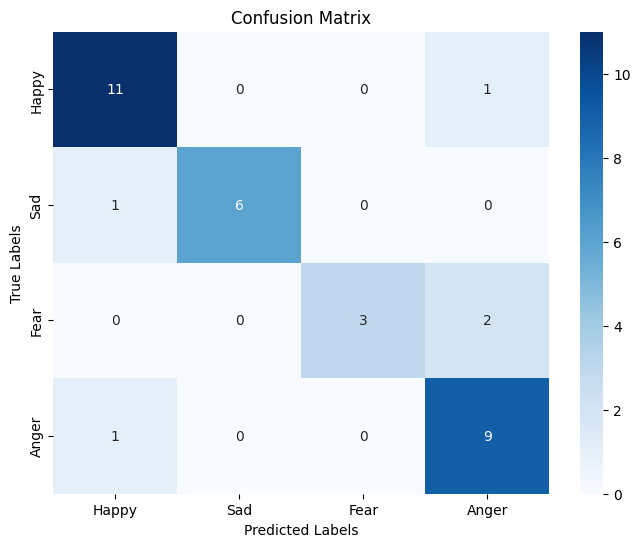

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# # Initialize the model again (with the same architecture)
# model = ImprovedEmotionTransformer().to(device)

# # Load the saved state dict
# model_load_path = "/content/drive/MyDrive/balanced.pth"
# model.load_state_dict(torch.load(model_load_path))
# model.eval()  # Set the model to evaluation mode
# print(f"Model loaded from {model_load_path}")

# Evaluate the model's performance
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)
        outputs = model(x_feat)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred, target_names=INT_TO_LABEL.values()))

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=INT_TO_LABEL.values(), yticklabels=INT_TO_LABEL.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
TARGET_SAMPLE_RATE = 44100
TARGET_AUDIO_LENGTH = 15 * TARGET_SAMPLE_RATE
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}
desired_emotions = list(LABEL_TO_INT.keys())

# Data loading
def load_dataset(csv_path, audio_dir):
    df = pd.read_csv(csv_path)
    df["Emotion"] = df["Emotion"].str.capitalize()
    df = df[df["Emotion"].isin(desired_emotions)].reset_index(drop=True)
    df["File"] = df["Nro"].astype(str).str.zfill(3) + ".mp3"
    df["DataDir"] = audio_dir
    return df

df1 = load_dataset("/content/drive/MyDrive/Moodify-CDS-2025/data/set1_tracklist.csv", "/content/drive/MyDrive/Moodify-CDS-2025/data/Set1")
df2 = load_dataset("/content/aggregated_emotions_for_model_1.csv", "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/classical")
df_combined = pd.concat([df1, df2]).reset_index(drop=True)

# Augmentation
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5)  # ← this was causing the error
])
# Audio utils
class Stereo2Mono(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.tensor([0.5, 0.5], requires_grad=False).view(2, 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            return torch.sum(waveform * self.weights, dim=0) * np.sqrt(2)
        return waveform

def path_to_waveform_tensor(path: str, sample_rate=TARGET_SAMPLE_RATE, augment_audio=True):
    waveform, sr = torchaudio.load(path)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    mono_wf = Stereo2Mono()(waveform)
    wf = mono_wf.squeeze(0).cpu().numpy()
    if augment_audio:
        wf = augment(samples=wf, sample_rate=sample_rate)
    return torch.tensor(wf)

def split_waveform_segments(wf: torch.Tensor, target_len=TARGET_AUDIO_LENGTH, min_length=TARGET_SAMPLE_RATE*10, train: bool=True):
    wf_len = wf.shape[0]
    if wf_len < target_len:
        return [wf.detach().clone()] if wf_len >= min_length else []
    else:
        hop_length = target_len // 2 if train else target_len
        segments = []
        for i in range(0, wf_len, hop_length):
            if wf_len - i > target_len:
                segments.append(wf[i:i+target_len])
            elif wf_len - i >= min_length:
                segments.append(wf[-target_len if train else i:])
        return segments

# Dataset
class AudioEmotionDataset(Dataset):
    def __init__(self, dataframe, train=True):
        self.dataframe = dataframe
        self.train = train
        self.data = []
        self.labels = []
        self.prepare_dataset()

    def prepare_dataset(self):
        for _, row in tqdm(self.dataframe.iterrows(), total=len(self.dataframe)):
            audio_path = os.path.join(row["DataDir"], row["File"])
            label = LABEL_TO_INT[row["Emotion"]]
            try:
                wf = path_to_waveform_tensor(audio_path, augment_audio=self.train)
                segments = split_waveform_segments(wf, train=self.train)
                self.data.extend(segments)
                self.labels.extend([label] * len(segments))
            except Exception as e:
                print(f"Error loading {audio_path}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Collate
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = pad_sequence(waveforms, batch_first=True)
    return waveforms, torch.tensor(labels)

# Feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=TARGET_SAMPLE_RATE, n_mels=128, n_fft=4096, center=True)

    def forward(self, x):
        x = self.melspec(x)
        x = torch.log(x + 1e-9)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer model
# class ImprovedEmotionTransformer(nn.Module):
#     def __init__(self, input_dim=128, num_classes=4, d_model=128, nhead=8, num_layers=12, dropout=0.6):
#         super().__init__()
#         self.input_proj = nn.Linear(input_dim, d_model)
#         self.pos_encoder = PositionalEncoding(d_model)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, dropout=dropout, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.dropout = nn.Dropout(dropout)
#         self.fc_out = nn.Linear(d_model, num_classes)

#     def forward(self, x):
#         x = x.permute(0, 2, 1)
#         x = self.input_proj(x)
#         x = self.pos_encoder(x)
#         x = self.transformer_encoder(x)
#         x = x.mean(dim=1)
#         return self.fc_out(self.dropout(x))

# Data split
full_dataset = AudioEmotionDataset(df_combined, train=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)

# Init model
extractor = FeatureExtractor().to(device)
# model = ImprovedEmotionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training
epochs = 400
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)

        optimizer.zero_grad()
        outputs = model(x_feat)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        x_feat = torch.stack([extractor(wf) for wf in x]).to(device)
        outputs = model(x_feat)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=INT_TO_LABEL.values()))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print(f"Weighted F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")


100%|██████████| 220/220 [00:38<00:00,  5.74it/s]


Error loading /content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/classical/401.mp3: Failed to open the input "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/classical/401.mp3" (No such file or directory).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7c876536c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7c8765315a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x7c879cba9034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::

Epoch 1/400: 100%|██████████| 17/17 [00:00<00:00, 42.19it/s]


Epoch 1, Loss: 2.5308


Epoch 2/400: 100%|██████████| 17/17 [00:00<00:00, 43.80it/s]


Epoch 2, Loss: 2.2158


Epoch 3/400: 100%|██████████| 17/17 [00:00<00:00, 45.42it/s]


Epoch 3, Loss: 2.4827


Epoch 4/400: 100%|██████████| 17/17 [00:00<00:00, 43.23it/s]


Epoch 4, Loss: 2.5055


Epoch 5/400: 100%|██████████| 17/17 [00:00<00:00, 43.80it/s]


Epoch 5, Loss: 2.4304


Epoch 6/400: 100%|██████████| 17/17 [00:00<00:00, 44.55it/s]


Epoch 6, Loss: 2.3425


Epoch 7/400: 100%|██████████| 17/17 [00:00<00:00, 44.49it/s]


Epoch 7, Loss: 2.3268


Epoch 8/400: 100%|██████████| 17/17 [00:00<00:00, 45.83it/s]


Epoch 8, Loss: 2.5630


Epoch 9/400: 100%|██████████| 17/17 [00:00<00:00, 45.28it/s]


Epoch 9, Loss: 2.3547


Epoch 10/400: 100%|██████████| 17/17 [00:00<00:00, 45.42it/s]


Epoch 10, Loss: 2.1548


Epoch 11/400: 100%|██████████| 17/17 [00:00<00:00, 45.32it/s]


Epoch 11, Loss: 2.2697


Epoch 12/400: 100%|██████████| 17/17 [00:00<00:00, 45.22it/s]


Epoch 12, Loss: 2.0869


Epoch 13/400: 100%|██████████| 17/17 [00:00<00:00, 45.58it/s]


Epoch 13, Loss: 2.2417


Epoch 14/400: 100%|██████████| 17/17 [00:00<00:00, 45.53it/s]


Epoch 14, Loss: 2.0802


Epoch 15/400: 100%|██████████| 17/17 [00:00<00:00, 45.56it/s]


Epoch 15, Loss: 2.3559


Epoch 16/400: 100%|██████████| 17/17 [00:00<00:00, 45.68it/s]


Epoch 16, Loss: 2.2055


Epoch 17/400: 100%|██████████| 17/17 [00:00<00:00, 42.54it/s]


Epoch 17, Loss: 2.0636


Epoch 18/400: 100%|██████████| 17/17 [00:00<00:00, 45.07it/s]


Epoch 18, Loss: 1.9914


Epoch 19/400: 100%|██████████| 17/17 [00:00<00:00, 45.23it/s]


Epoch 19, Loss: 2.1546


Epoch 20/400: 100%|██████████| 17/17 [00:00<00:00, 45.23it/s]


Epoch 20, Loss: 2.0239


Epoch 21/400: 100%|██████████| 17/17 [00:00<00:00, 44.99it/s]


Epoch 21, Loss: 2.1648


Epoch 22/400: 100%|██████████| 17/17 [00:00<00:00, 45.21it/s]


Epoch 22, Loss: 2.0982


Epoch 23/400: 100%|██████████| 17/17 [00:00<00:00, 44.88it/s]


Epoch 23, Loss: 2.2962


Epoch 24/400: 100%|██████████| 17/17 [00:00<00:00, 44.40it/s]


Epoch 24, Loss: 2.0793


Epoch 25/400: 100%|██████████| 17/17 [00:00<00:00, 45.56it/s]


Epoch 25, Loss: 2.1507


Epoch 26/400: 100%|██████████| 17/17 [00:00<00:00, 45.44it/s]


Epoch 26, Loss: 2.2315


Epoch 27/400: 100%|██████████| 17/17 [00:00<00:00, 45.46it/s]


Epoch 27, Loss: 1.9773


Epoch 28/400: 100%|██████████| 17/17 [00:00<00:00, 45.06it/s]


Epoch 28, Loss: 2.0665


Epoch 29/400: 100%|██████████| 17/17 [00:00<00:00, 44.29it/s]


Epoch 29, Loss: 2.0683


Epoch 30/400: 100%|██████████| 17/17 [00:00<00:00, 44.49it/s]


Epoch 30, Loss: 2.0721


Epoch 31/400: 100%|██████████| 17/17 [00:00<00:00, 44.42it/s]


Epoch 31, Loss: 2.0199


Epoch 32/400: 100%|██████████| 17/17 [00:00<00:00, 44.52it/s]


Epoch 32, Loss: 2.1493


Epoch 33/400: 100%|██████████| 17/17 [00:00<00:00, 44.19it/s]


Epoch 33, Loss: 1.9039


Epoch 34/400: 100%|██████████| 17/17 [00:00<00:00, 44.01it/s]


Epoch 34, Loss: 2.1811


Epoch 35/400: 100%|██████████| 17/17 [00:00<00:00, 44.72it/s]


Epoch 35, Loss: 2.1455


Epoch 36/400: 100%|██████████| 17/17 [00:00<00:00, 44.20it/s]


Epoch 36, Loss: 2.0557


Epoch 37/400: 100%|██████████| 17/17 [00:00<00:00, 44.31it/s]


Epoch 37, Loss: 2.1735


Epoch 38/400: 100%|██████████| 17/17 [00:00<00:00, 46.19it/s]


Epoch 38, Loss: 2.1697


Epoch 39/400: 100%|██████████| 17/17 [00:00<00:00, 45.71it/s]


Epoch 39, Loss: 1.8761


Epoch 40/400: 100%|██████████| 17/17 [00:00<00:00, 44.64it/s]


Epoch 40, Loss: 1.9911


Epoch 41/400: 100%|██████████| 17/17 [00:00<00:00, 44.93it/s]


Epoch 41, Loss: 2.0499


Epoch 42/400: 100%|██████████| 17/17 [00:00<00:00, 45.86it/s]


Epoch 42, Loss: 2.1457


Epoch 43/400: 100%|██████████| 17/17 [00:00<00:00, 44.73it/s]


Epoch 43, Loss: 1.9756


Epoch 44/400: 100%|██████████| 17/17 [00:00<00:00, 44.95it/s]


Epoch 44, Loss: 1.9965


Epoch 45/400: 100%|██████████| 17/17 [00:00<00:00, 45.47it/s]


Epoch 45, Loss: 1.9392


Epoch 46/400: 100%|██████████| 17/17 [00:00<00:00, 45.01it/s]


Epoch 46, Loss: 2.1267


Epoch 47/400: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s]


Epoch 47, Loss: 2.1250


Epoch 48/400: 100%|██████████| 17/17 [00:00<00:00, 45.55it/s]


Epoch 48, Loss: 2.2046


Epoch 49/400: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s]


Epoch 49, Loss: 2.0704


Epoch 50/400: 100%|██████████| 17/17 [00:00<00:00, 45.21it/s]


Epoch 50, Loss: 2.0487


Epoch 51/400: 100%|██████████| 17/17 [00:00<00:00, 44.58it/s]


Epoch 51, Loss: 2.1355


Epoch 52/400: 100%|██████████| 17/17 [00:00<00:00, 44.73it/s]


Epoch 52, Loss: 1.9298


Epoch 53/400: 100%|██████████| 17/17 [00:00<00:00, 45.45it/s]


Epoch 53, Loss: 2.0435


Epoch 54/400: 100%|██████████| 17/17 [00:00<00:00, 45.43it/s]


Epoch 54, Loss: 2.1077


Epoch 55/400: 100%|██████████| 17/17 [00:00<00:00, 44.20it/s]


Epoch 55, Loss: 1.9609


Epoch 56/400: 100%|██████████| 17/17 [00:00<00:00, 42.70it/s]


Epoch 56, Loss: 2.0465


Epoch 57/400: 100%|██████████| 17/17 [00:00<00:00, 44.64it/s]


Epoch 57, Loss: 2.2258


Epoch 58/400: 100%|██████████| 17/17 [00:00<00:00, 44.77it/s]


Epoch 58, Loss: 2.0293


Epoch 59/400: 100%|██████████| 17/17 [00:00<00:00, 45.01it/s]


Epoch 59, Loss: 2.1886


Epoch 60/400: 100%|██████████| 17/17 [00:00<00:00, 44.66it/s]


Epoch 60, Loss: 2.1866


Epoch 61/400: 100%|██████████| 17/17 [00:00<00:00, 45.51it/s]


Epoch 61, Loss: 2.0441


Epoch 62/400: 100%|██████████| 17/17 [00:00<00:00, 45.53it/s]


Epoch 62, Loss: 1.7492


Epoch 63/400: 100%|██████████| 17/17 [00:00<00:00, 44.27it/s]


Epoch 63, Loss: 2.0539


Epoch 64/400: 100%|██████████| 17/17 [00:00<00:00, 44.63it/s]


Epoch 64, Loss: 1.9863


Epoch 65/400: 100%|██████████| 17/17 [00:00<00:00, 43.14it/s]


Epoch 65, Loss: 2.0928


Epoch 66/400: 100%|██████████| 17/17 [00:00<00:00, 44.92it/s]


Epoch 66, Loss: 2.0678


Epoch 67/400: 100%|██████████| 17/17 [00:00<00:00, 43.77it/s]


Epoch 67, Loss: 1.9985


Epoch 68/400: 100%|██████████| 17/17 [00:00<00:00, 43.37it/s]


Epoch 68, Loss: 1.9768


Epoch 69/400: 100%|██████████| 17/17 [00:00<00:00, 44.68it/s]


Epoch 69, Loss: 2.0371


Epoch 70/400: 100%|██████████| 17/17 [00:00<00:00, 46.20it/s]


Epoch 70, Loss: 2.0222


Epoch 71/400: 100%|██████████| 17/17 [00:00<00:00, 42.20it/s]


Epoch 71, Loss: 1.9600


Epoch 72/400: 100%|██████████| 17/17 [00:00<00:00, 45.45it/s]


Epoch 72, Loss: 2.0222


Epoch 73/400: 100%|██████████| 17/17 [00:00<00:00, 45.48it/s]


Epoch 73, Loss: 1.9818


Epoch 74/400: 100%|██████████| 17/17 [00:00<00:00, 44.47it/s]


Epoch 74, Loss: 1.9990


Epoch 75/400: 100%|██████████| 17/17 [00:00<00:00, 45.40it/s]


Epoch 75, Loss: 2.0545


Epoch 76/400: 100%|██████████| 17/17 [00:00<00:00, 45.37it/s]


Epoch 76, Loss: 1.9881


Epoch 77/400: 100%|██████████| 17/17 [00:00<00:00, 45.25it/s]


Epoch 77, Loss: 1.9782


Epoch 78/400: 100%|██████████| 17/17 [00:00<00:00, 44.43it/s]


Epoch 78, Loss: 2.0830


Epoch 79/400: 100%|██████████| 17/17 [00:00<00:00, 44.83it/s]


Epoch 79, Loss: 1.9719


Epoch 80/400: 100%|██████████| 17/17 [00:00<00:00, 43.93it/s]


Epoch 80, Loss: 2.0657


Epoch 81/400: 100%|██████████| 17/17 [00:00<00:00, 45.03it/s]


Epoch 81, Loss: 1.8943


Epoch 82/400: 100%|██████████| 17/17 [00:00<00:00, 45.32it/s]


Epoch 82, Loss: 2.1420


Epoch 83/400: 100%|██████████| 17/17 [00:00<00:00, 45.97it/s]


Epoch 83, Loss: 1.9448


Epoch 84/400: 100%|██████████| 17/17 [00:00<00:00, 43.64it/s]


Epoch 84, Loss: 1.8457


Epoch 85/400: 100%|██████████| 17/17 [00:00<00:00, 43.37it/s]


Epoch 85, Loss: 1.9600


Epoch 86/400: 100%|██████████| 17/17 [00:00<00:00, 45.49it/s]


Epoch 86, Loss: 1.8023


Epoch 87/400: 100%|██████████| 17/17 [00:00<00:00, 44.40it/s]


Epoch 87, Loss: 1.9187


Epoch 88/400: 100%|██████████| 17/17 [00:00<00:00, 44.51it/s]


Epoch 88, Loss: 1.9095


Epoch 89/400: 100%|██████████| 17/17 [00:00<00:00, 44.41it/s]


Epoch 89, Loss: 1.8923


Epoch 90/400: 100%|██████████| 17/17 [00:00<00:00, 44.47it/s]


Epoch 90, Loss: 1.8883


Epoch 91/400: 100%|██████████| 17/17 [00:00<00:00, 44.78it/s]


Epoch 91, Loss: 1.9210


Epoch 92/400: 100%|██████████| 17/17 [00:00<00:00, 44.19it/s]


Epoch 92, Loss: 1.8913


Epoch 93/400: 100%|██████████| 17/17 [00:00<00:00, 45.49it/s]


Epoch 93, Loss: 2.0752


Epoch 94/400: 100%|██████████| 17/17 [00:00<00:00, 43.42it/s]


Epoch 94, Loss: 1.9334


Epoch 95/400: 100%|██████████| 17/17 [00:00<00:00, 45.05it/s]


Epoch 95, Loss: 1.8300


Epoch 96/400: 100%|██████████| 17/17 [00:00<00:00, 44.85it/s]


Epoch 96, Loss: 1.7739


Epoch 97/400: 100%|██████████| 17/17 [00:00<00:00, 45.57it/s]


Epoch 97, Loss: 1.9794


Epoch 98/400: 100%|██████████| 17/17 [00:00<00:00, 45.93it/s]


Epoch 98, Loss: 1.8170


Epoch 99/400: 100%|██████████| 17/17 [00:00<00:00, 44.68it/s]


Epoch 99, Loss: 1.8527


Epoch 100/400: 100%|██████████| 17/17 [00:00<00:00, 46.03it/s]


Epoch 100, Loss: 1.9091


Epoch 101/400: 100%|██████████| 17/17 [00:00<00:00, 45.99it/s]


Epoch 101, Loss: 1.6931


Epoch 102/400: 100%|██████████| 17/17 [00:00<00:00, 45.87it/s]


Epoch 102, Loss: 1.8465


Epoch 103/400: 100%|██████████| 17/17 [00:00<00:00, 45.85it/s]


Epoch 103, Loss: 1.8723


Epoch 104/400: 100%|██████████| 17/17 [00:00<00:00, 46.15it/s]


Epoch 104, Loss: 1.9400


Epoch 105/400: 100%|██████████| 17/17 [00:00<00:00, 45.48it/s]


Epoch 105, Loss: 1.8640


Epoch 106/400: 100%|██████████| 17/17 [00:00<00:00, 46.35it/s]


Epoch 106, Loss: 1.8121


Epoch 107/400: 100%|██████████| 17/17 [00:00<00:00, 45.37it/s]


Epoch 107, Loss: 1.7403


Epoch 108/400: 100%|██████████| 17/17 [00:00<00:00, 44.41it/s]


Epoch 108, Loss: 1.7860


Epoch 109/400: 100%|██████████| 17/17 [00:00<00:00, 45.13it/s]


Epoch 109, Loss: 1.7954


Epoch 110/400: 100%|██████████| 17/17 [00:00<00:00, 43.60it/s]


Epoch 110, Loss: 1.8346


Epoch 111/400: 100%|██████████| 17/17 [00:00<00:00, 45.10it/s]


Epoch 111, Loss: 1.7940


Epoch 112/400: 100%|██████████| 17/17 [00:00<00:00, 44.83it/s]


Epoch 112, Loss: 1.8381


Epoch 113/400: 100%|██████████| 17/17 [00:00<00:00, 43.07it/s]


Epoch 113, Loss: 1.8239


Epoch 114/400: 100%|██████████| 17/17 [00:00<00:00, 43.00it/s]


Epoch 114, Loss: 1.7812


Epoch 115/400: 100%|██████████| 17/17 [00:00<00:00, 43.21it/s]


Epoch 115, Loss: 1.7923


Epoch 116/400: 100%|██████████| 17/17 [00:00<00:00, 43.19it/s]


Epoch 116, Loss: 1.7444


Epoch 117/400: 100%|██████████| 17/17 [00:00<00:00, 42.69it/s]


Epoch 117, Loss: 1.6021


Epoch 118/400: 100%|██████████| 17/17 [00:00<00:00, 42.90it/s]


Epoch 118, Loss: 1.8122


Epoch 119/400: 100%|██████████| 17/17 [00:00<00:00, 45.66it/s]


Epoch 119, Loss: 1.8093


Epoch 120/400: 100%|██████████| 17/17 [00:00<00:00, 45.67it/s]


Epoch 120, Loss: 1.7344


Epoch 121/400: 100%|██████████| 17/17 [00:00<00:00, 45.24it/s]


Epoch 121, Loss: 1.6670


Epoch 122/400: 100%|██████████| 17/17 [00:00<00:00, 44.25it/s]


Epoch 122, Loss: 1.6835


Epoch 123/400: 100%|██████████| 17/17 [00:00<00:00, 43.45it/s]


Epoch 123, Loss: 1.7652


Epoch 124/400: 100%|██████████| 17/17 [00:00<00:00, 44.18it/s]


Epoch 124, Loss: 1.6931


Epoch 125/400: 100%|██████████| 17/17 [00:00<00:00, 44.09it/s]


Epoch 125, Loss: 1.8375


Epoch 126/400: 100%|██████████| 17/17 [00:00<00:00, 45.19it/s]


Epoch 126, Loss: 1.7602


Epoch 127/400: 100%|██████████| 17/17 [00:00<00:00, 44.03it/s]


Epoch 127, Loss: 1.7890


Epoch 128/400: 100%|██████████| 17/17 [00:00<00:00, 44.38it/s]


Epoch 128, Loss: 1.7832


Epoch 129/400: 100%|██████████| 17/17 [00:00<00:00, 44.09it/s]


Epoch 129, Loss: 1.7046


Epoch 130/400: 100%|██████████| 17/17 [00:00<00:00, 43.80it/s]


Epoch 130, Loss: 1.7923


Epoch 131/400: 100%|██████████| 17/17 [00:00<00:00, 43.64it/s]


Epoch 131, Loss: 1.6651


Epoch 132/400: 100%|██████████| 17/17 [00:00<00:00, 45.25it/s]


Epoch 132, Loss: 1.6209


Epoch 133/400: 100%|██████████| 17/17 [00:00<00:00, 44.71it/s]


Epoch 133, Loss: 1.9341


Epoch 134/400: 100%|██████████| 17/17 [00:00<00:00, 45.57it/s]


Epoch 134, Loss: 1.6885


Epoch 135/400: 100%|██████████| 17/17 [00:00<00:00, 43.52it/s]


Epoch 135, Loss: 1.6031


Epoch 136/400: 100%|██████████| 17/17 [00:00<00:00, 43.05it/s]


Epoch 136, Loss: 1.8609


Epoch 137/400: 100%|██████████| 17/17 [00:00<00:00, 44.28it/s]


Epoch 137, Loss: 1.7111


Epoch 138/400: 100%|██████████| 17/17 [00:00<00:00, 43.94it/s]


Epoch 138, Loss: 1.6835


Epoch 139/400: 100%|██████████| 17/17 [00:00<00:00, 45.05it/s]


Epoch 139, Loss: 1.7440


Epoch 140/400: 100%|██████████| 17/17 [00:00<00:00, 43.66it/s]


Epoch 140, Loss: 1.6988


Epoch 141/400: 100%|██████████| 17/17 [00:00<00:00, 44.19it/s]


Epoch 141, Loss: 1.8079


Epoch 142/400: 100%|██████████| 17/17 [00:00<00:00, 44.55it/s]


Epoch 142, Loss: 1.8031


Epoch 143/400: 100%|██████████| 17/17 [00:00<00:00, 45.49it/s]


Epoch 143, Loss: 1.6406


Epoch 144/400: 100%|██████████| 17/17 [00:00<00:00, 45.32it/s]


Epoch 144, Loss: 1.7169


Epoch 145/400: 100%|██████████| 17/17 [00:00<00:00, 45.31it/s]


Epoch 145, Loss: 1.7436


Epoch 146/400: 100%|██████████| 17/17 [00:00<00:00, 44.11it/s]


Epoch 146, Loss: 1.7964


Epoch 147/400: 100%|██████████| 17/17 [00:00<00:00, 45.31it/s]


Epoch 147, Loss: 1.7178


Epoch 148/400: 100%|██████████| 17/17 [00:00<00:00, 44.91it/s]


Epoch 148, Loss: 1.5998


Epoch 149/400: 100%|██████████| 17/17 [00:00<00:00, 45.38it/s]


Epoch 149, Loss: 1.7133


Epoch 150/400: 100%|██████████| 17/17 [00:00<00:00, 45.67it/s]


Epoch 150, Loss: 1.7172


Epoch 151/400: 100%|██████████| 17/17 [00:00<00:00, 44.92it/s]


Epoch 151, Loss: 1.7794


Epoch 152/400: 100%|██████████| 17/17 [00:00<00:00, 44.54it/s]


Epoch 152, Loss: 1.6905


Epoch 153/400: 100%|██████████| 17/17 [00:00<00:00, 45.66it/s]


Epoch 153, Loss: 1.7730


Epoch 154/400: 100%|██████████| 17/17 [00:00<00:00, 44.57it/s]


Epoch 154, Loss: 1.7704


Epoch 155/400: 100%|██████████| 17/17 [00:00<00:00, 44.78it/s]


Epoch 155, Loss: 1.8566


Epoch 156/400: 100%|██████████| 17/17 [00:00<00:00, 44.23it/s]


Epoch 156, Loss: 1.6420


Epoch 157/400: 100%|██████████| 17/17 [00:00<00:00, 43.13it/s]


Epoch 157, Loss: 1.6849


Epoch 158/400: 100%|██████████| 17/17 [00:00<00:00, 42.96it/s]


Epoch 158, Loss: 1.7176


Epoch 159/400: 100%|██████████| 17/17 [00:00<00:00, 43.36it/s]


Epoch 159, Loss: 1.8550


Epoch 160/400: 100%|██████████| 17/17 [00:00<00:00, 44.11it/s]


Epoch 160, Loss: 1.5650


Epoch 161/400: 100%|██████████| 17/17 [00:00<00:00, 43.13it/s]


Epoch 161, Loss: 1.6752


Epoch 162/400: 100%|██████████| 17/17 [00:00<00:00, 42.71it/s]


Epoch 162, Loss: 1.6671


Epoch 163/400: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s]


Epoch 163, Loss: 1.7143


Epoch 164/400: 100%|██████████| 17/17 [00:00<00:00, 45.58it/s]


Epoch 164, Loss: 1.5910


Epoch 165/400: 100%|██████████| 17/17 [00:00<00:00, 45.29it/s]


Epoch 165, Loss: 1.8578


Epoch 166/400: 100%|██████████| 17/17 [00:00<00:00, 44.95it/s]


Epoch 166, Loss: 1.7356


Epoch 167/400: 100%|██████████| 17/17 [00:00<00:00, 45.18it/s]


Epoch 167, Loss: 1.7981


Epoch 168/400: 100%|██████████| 17/17 [00:00<00:00, 44.99it/s]


Epoch 168, Loss: 1.7002


Epoch 169/400: 100%|██████████| 17/17 [00:00<00:00, 44.64it/s]


Epoch 169, Loss: 1.6893


Epoch 170/400: 100%|██████████| 17/17 [00:00<00:00, 45.73it/s]


Epoch 170, Loss: 1.7586


Epoch 171/400: 100%|██████████| 17/17 [00:00<00:00, 45.92it/s]


Epoch 171, Loss: 1.8026


Epoch 172/400: 100%|██████████| 17/17 [00:00<00:00, 45.35it/s]


Epoch 172, Loss: 1.7546


Epoch 173/400: 100%|██████████| 17/17 [00:00<00:00, 46.18it/s]


Epoch 173, Loss: 1.7590


Epoch 174/400: 100%|██████████| 17/17 [00:00<00:00, 44.84it/s]


Epoch 174, Loss: 1.7795


Epoch 175/400: 100%|██████████| 17/17 [00:00<00:00, 45.33it/s]


Epoch 175, Loss: 1.7291


Epoch 176/400: 100%|██████████| 17/17 [00:00<00:00, 43.46it/s]


Epoch 176, Loss: 1.8025


Epoch 177/400: 100%|██████████| 17/17 [00:00<00:00, 45.30it/s]


Epoch 177, Loss: 1.6450


Epoch 178/400: 100%|██████████| 17/17 [00:00<00:00, 45.59it/s]


Epoch 178, Loss: 1.7583


Epoch 179/400: 100%|██████████| 17/17 [00:00<00:00, 44.88it/s]


Epoch 179, Loss: 1.6348


Epoch 180/400: 100%|██████████| 17/17 [00:00<00:00, 44.58it/s]


Epoch 180, Loss: 1.6851


Epoch 181/400: 100%|██████████| 17/17 [00:00<00:00, 45.26it/s]


Epoch 181, Loss: 1.6909


Epoch 182/400: 100%|██████████| 17/17 [00:00<00:00, 45.19it/s]


Epoch 182, Loss: 1.6449


Epoch 183/400: 100%|██████████| 17/17 [00:00<00:00, 45.33it/s]


Epoch 183, Loss: 1.7527


Epoch 184/400: 100%|██████████| 17/17 [00:00<00:00, 45.44it/s]


Epoch 184, Loss: 1.7247


Epoch 185/400: 100%|██████████| 17/17 [00:00<00:00, 44.25it/s]


Epoch 185, Loss: 1.6387


Epoch 186/400: 100%|██████████| 17/17 [00:00<00:00, 45.25it/s]


Epoch 186, Loss: 1.6350


Epoch 187/400: 100%|██████████| 17/17 [00:00<00:00, 45.53it/s]


Epoch 187, Loss: 1.7121


Epoch 188/400: 100%|██████████| 17/17 [00:00<00:00, 43.82it/s]


Epoch 188, Loss: 1.7070


Epoch 189/400: 100%|██████████| 17/17 [00:00<00:00, 43.87it/s]


Epoch 189, Loss: 1.7613


Epoch 190/400: 100%|██████████| 17/17 [00:00<00:00, 44.07it/s]


Epoch 190, Loss: 1.7893


Epoch 191/400: 100%|██████████| 17/17 [00:00<00:00, 42.07it/s]


Epoch 191, Loss: 1.6893


Epoch 192/400: 100%|██████████| 17/17 [00:00<00:00, 44.01it/s]


Epoch 192, Loss: 1.7953


Epoch 193/400: 100%|██████████| 17/17 [00:00<00:00, 42.50it/s]


Epoch 193, Loss: 1.6733


Epoch 194/400: 100%|██████████| 17/17 [00:00<00:00, 42.93it/s]


Epoch 194, Loss: 1.6468


Epoch 195/400: 100%|██████████| 17/17 [00:00<00:00, 45.35it/s]


Epoch 195, Loss: 1.6143


Epoch 196/400: 100%|██████████| 17/17 [00:00<00:00, 45.42it/s]


Epoch 196, Loss: 1.6482


Epoch 197/400: 100%|██████████| 17/17 [00:00<00:00, 45.28it/s]


Epoch 197, Loss: 1.6742


Epoch 198/400: 100%|██████████| 17/17 [00:00<00:00, 45.13it/s]


Epoch 198, Loss: 1.6718


Epoch 199/400:  59%|█████▉    | 10/17 [00:00<00:00, 41.91it/s]


KeyboardInterrupt: 

In [ ]:
!pip install audiomentations


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 892.3 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of numpy-minmax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpy-rms to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0

In [3]:
import torch
import torchaudio
import numpy as np
import librosa

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
TARGET_SAMPLE_RATE = 44100
TARGET_AUDIO_LENGTH = 15 * TARGET_SAMPLE_RATE
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}

# Load utilities
class Stereo2Mono(torch.nn.Module):
    def forward(self, waveform):
        if waveform.shape[0] == 2:
            return (waveform[0] + waveform[1]) / np.sqrt(2)
        return waveform[0]

class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE,
            n_mels=128,
            n_fft=4096,
            center=True
        )

    def forward(self, x):
        x = self.melspec(x)
        x = torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))
        return x

def preprocess_audio(path):
    waveform, sr = torchaudio.load(path)
    if sr != TARGET_SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, TARGET_SAMPLE_RATE)(waveform)
    mono = Stereo2Mono()(waveform).to(device)

    # Pad or crop to 15 seconds
    if mono.shape[0] < TARGET_AUDIO_LENGTH:
        padding = TARGET_AUDIO_LENGTH - mono.shape[0]
        mono = torch.nn.functional.pad(mono, (0, padding))
    else:
        mono = mono[:TARGET_AUDIO_LENGTH]
    return mono

def predict_emotion(audio_path, model, extractor):
    model.eval()
    waveform = preprocess_audio(audio_path)
    with torch.no_grad():
        features = extractor(waveform)
        features = features.unsqueeze(0).to(device)  # Add batch dimension
        output = model(features)
        prediction = torch.argmax(output, dim=1).item()
        return INT_TO_LABEL[prediction]


In [5]:
audio_path = "/content/drive/MyDrive/Moodify-CDS-2025/emotifymusic/classical/75.mp3"
extractor = FeatureExtractor().to(device)
model = 
emotion = predict_emotion(audio_path, model, extractor)
print(f"Predicted Emotion: {emotion}")


NameError: name 'ImprovedEmotionTransformer' is not defined

In [19]:
import torch
import torchaudio
import numpy as np
import librosa
import torch.nn as nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
TARGET_SAMPLE_RATE = 44100
TARGET_AUDIO_LENGTH = 15 * TARGET_SAMPLE_RATE
LABEL_TO_INT = {"Happy": 0, "Sad": 1, "Fear": 2, "Anger": 3}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}

# Load utilities
class Stereo2Mono(torch.nn.Module):
    def forward(self, waveform):
        if waveform.shape[0] == 2:
            return (waveform[0] + waveform[1]) / np.sqrt(2)
        return waveform[0]

class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE,
            n_mels=128,
            n_fft=4096,
            center=True
        )

    def forward(self, x):
        x = self.melspec(x)
        x = torch.from_numpy(librosa.power_to_db(x.cpu().numpy(), ref=np.max))
        return x

def preprocess_audio(path):
    waveform, sr = torchaudio.load(path)
    if sr != TARGET_SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, TARGET_SAMPLE_RATE)(waveform)
    mono = Stereo2Mono()(waveform).to(device)

    # Pad or crop to 15 seconds
    if mono.shape[0] < TARGET_AUDIO_LENGTH:
        padding = TARGET_AUDIO_LENGTH - mono.shape[0]
        mono = torch.nn.functional.pad(mono, (0, padding))
    else:
        mono = mono[:TARGET_AUDIO_LENGTH]
    return mono

def predict_emotion(audio_path, model, extractor):
    model.eval()
    waveform = preprocess_audio(audio_path)
    with torch.no_grad():
        features = extractor(waveform)
        features = features.unsqueeze(0).to(device)  
        output = model(features)
        prediction = torch.argmax(output, dim=1).item()
        return INT_TO_LABEL[prediction]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    
class ImprovedEmotionTransformer(nn.Module):
    def __init__(self, input_dim=128, num_classes=4, d_model=128, nhead=8, num_layers=4, dropout=0.7):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)               # (B, T, F)
        x = self.input_proj(x)               # (B, T, D)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)               # (T, B, D)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)                    # (B, D)
        x = self.dropout(x)
        return self.fc_out(x)
    
extractor = FeatureExtractor().to(device)
model = ImprovedEmotionTransformer().to(device)

# Load the saved state dict
model_load_path = "/Users/jigneshmotwani/Moodify-CDS-2025/balanced2.pth"
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu'))) 
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_load_path}")
audio_path = "/Users/jigneshmotwani/Moodify-CDS-2025/data/SoundTracks/Set1/075.mp3"
emotion = predict_emotion(audio_path, model, extractor)
print(f"Predicted Emotion: {emotion}")


Model loaded from /Users/jigneshmotwani/Moodify-CDS-2025/balanced2.pth
Predicted Emotion: Happy
